# Starsim tutorial

#### A step by step tutorial on using starsim

## What is starsim?
Starsim is a tool to simulate photometry and spectroscopy of a spotted rotating star. It has two main modes:
* **Forward mode**: From a custom spot map and stellar parameters, allows simulating photometry (light curves at different bandpass) and spectroscopy (RV, FWHM, BIS, contrast, CRX) at the desired times of observation.
* **Inverse mode**: From multiple (or single) time series of different observables and instruments, derive the spot map and the stellar parameters that best reproduce the input parameters.

## 1.- Installation

**WARNING**: Before installation, be aware that starsim can be only executed using Python 3.X, so make sure it is your default version. Otherwise, you can create a new enviroment with [anaconda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) or alternatively, in the following steps use `pip3` instead of `pip` and run any script with `python3 script.py` instead of `python script.py`.

Starsim can be downloaded from github, and installed using pip. Simply run:
```
git clone https://github.com/dbarochlopez/starsim.git
cd starsim
pip install .
```
Now starsim is installed and can be imported from any location.

## 2.-Downloading models
The main engine of starsim is based on synthetic spectra to generate the surface grid. In order to work, starsim needs two types of models, high-resolution models and intensity models, both based on the stellar atmosphere code PHOENIX ([Allard & Hauschildt 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...445..433A/abstract)) computed by [Husser et al. (2013)](https://www.aanda.org/articles/aa/full_html/2013/05/aa19058-12/aa19058-12.html#R1).

You can download them from https://www.ice.csic.es/owncloud/s/7kRTAJqKHxeHB3w, and replace the _starsim/models_ folder with the downloaded folder. The downloaded models contains temperatures from 2300K to 5500K, and surface gravities from 3.5 to 6.0. If a wider grid of temperatures and/or surface gravities are needed, the high resolution models can be found in http://phoenix.astro.physik.uni-goettingen.de/data/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/ (store them in models/Phoenix) and the intensity models in http://phoenix.astro.physik.uni-goettingen.de/data/SpecIntFITS/PHOENIX-ACES-AGSS-COND-SPECINT-2011/Z-0.0/ (store them in models/Phoenix_mu). **IMPORTANT**: if you download a new high-resolution model to models/Phoenix, the corresponding intensity model must be downloaded to models/Phoenix_mu, and vice versa. In case a model is missing, starsim will let you know.

Additionaly, the folder _starsim/models/filters_ contains some files with the bandpass of different instruments (TESS, Kepler, etc.). If you want to use different filters, you can create your own file, or download [here](http://svo2.cab.inta-csic.es/svo/theory/fps3/) the bandpass of the desired instrument.

## 3.- Setting up the configuration files

The definition of the stellar parameters, the spot map, and other options is made through two main files in the _starsim_ folder: starsim.conf and spotmap.dat.

* **starsim.conf**: used to set the stellar parameters and different modes and options of the simulation. The file is intended to be self-explanatory.
* **spotmap.dat**: used to define the spots appearence, lifetime, position, and radius. Each row correspond to a different spot. There are 14 columns. The first seven columns are: 1-Appearence time, 2-Lifetime, 3-Colatitude, 4-longitude (at the ref. time set in starsim.conf) 5,6,7-Coefficients determining the evolution of the radius of the spot, the behaviour depends on the _spots_evo_law_ set in starsim.conf (_spots_evo_law_=constant will only use column 5, and the radii will be constant. _spots_evo_law_=linear will use columns 5 and 6, and the radii will evolve from the value in column 5 to the value in column 6. More evolution laws will be added in the future. Columns 8 to 14  are only used in the inversion mode. They are related to the parameter 7 columns to the left, and are flags indicating if the parameter of the spot will be fixed (0) or optimized (1). E.g., column 9 of row 3 set to 1 means that the lifetime (column 2) of spot 3 (row 3) will be optimized.

## 4.- Starting the program

starsim can be executed from your terminal or through a python script. First, you have to import the starsim module and define an starsim object containing the info in starsim.conf and spotmap.dat.


In [1]:
import starsim

ss=starsim.StarSim(conf_file_path='starsim.conf')

The object ss now contains all the info in starsim.conf and spotmap.dat. After ss is defined, the options and spotmap can be accesed and modified without the need of rewriting the files, using ss.NAME_PARAM, with NAME_PARAM equal to the parameter name in starsim.conf. Lets check the current value of the rotation period and modify it to 2.5 days.

In [2]:
print(ss.rotation_period)
ss.rotation_period=2.5
print(ss.rotation_period)

10.0
2.5


Likewise, we can check and modify the spot map by using the command ss.spot_map. Lets check the colatitude of the first spot. The first index corresponds to the row, and the second index to the column. Remember that the first index in python is 0.

In [3]:
print('The first spot (index 0) is at a colatitude (index 2) of:')
print(ss.spot_map[0][2])

The first spot (index 0) is at a colatitude (index 2) of:
90.0


Before starting with the modeling, it is convenient to explain the two main modes of creating the surface grid available in starsim, which can be selected under the _simulation_mode_ keyword in starsim.conf.
* **Fast**: The stellar surface is simulated by a grid of photosphere elements with the same temperature and different limb darkening. Spots and faculae is treated as a single grid element, with properties defined by the coordinates of the central coordinate. This mode is relatively fast, but it is not recommended for spots with radii larger than 15-20 deg. The projected fillingfactor is not affected by this mode as it is analitically computed. 
* **Grid**: The stellar surface is simulated by a grid of different elements (spot, photosphere and facule), to which we assign the corresponding spectra and limb darkening. This option is a bit slower than the fast mode, but should be used for large spots, since different parts of the same spot have noticeabily different limb darkening/spectra. The size of the grid elements is controled by the ``n_grid_rings`` keyword. The width of a grid will be $180/(2\cdot n\_grid\_rings-1)$, in deg. For a decent computing time to resolution ratio, use a number of grids equal to $\max\{10,int(120/R)\}$, with R equal to the radius (in deg) of the smallest spot.

## 5.- Forward modeling

With the forward modeling, the user defines a spot map and a set of stellar parameters, and starsim simulates different observables at the required time stamps.

First, we import starsim and create the starsim object, as before. Then we create a simple spot map, with one 5 deg spot in the equator born at t=-1 and a liftime of 40 days.


In [4]:
import starsim 
import numpy as np
import matplotlib.pyplot as plt
#Create starsim objec, reads starsim.conf and spotmap.dat
ss=starsim.StarSim(conf_file_path='starsim.conf')
#Create a simple spot map. Only one spot. We initialize the map with all zeros.
ss.spot_map=np.zeros([1,14]) #One row, 14 columns. 14 columns are mandatory, the number of rows is the number of spots.
ss.spot_map[0][0]=-1 #appearence time in t=-1
ss.spot_map[0][1]=40 #lifetime of 40 days
ss.spot_map[0][2]=90 #colatitude 90 deg
ss.spot_map[0][4]=5 #spotsize 5 deg (using constant evo. law)

Then we execute the forward model, giving the times at which we want to simulate, and the observables we want, in this case the lightcurve, the radial velocities and the fwhm.

In [5]:
t_sampling=np.linspace(0,30,200) #sampling times

ss.compute_forward(observables=['lc','rv','fwhm'],t=t_sampling) #Available observables: (lc,rv,crx). bis, fwhm and contrast are aliases of rv.

The results are saved under the dictionary ss.results. Lets chek them with a couple of plots.

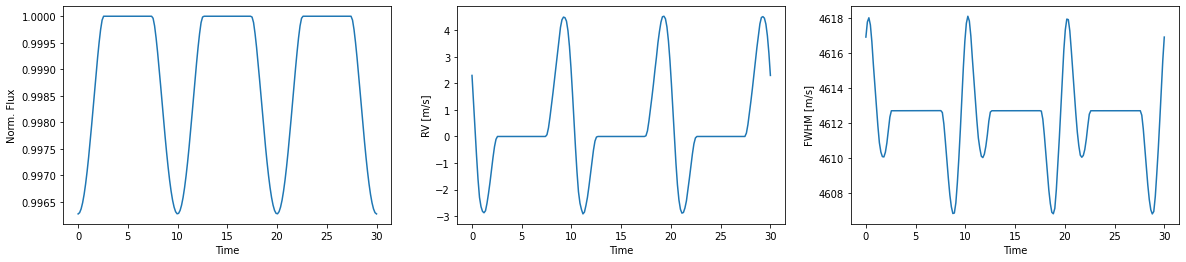

In [6]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(t_sampling,ss.results['lc'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Norm. Flux')
ax[1].plot(t_sampling,ss.results['rv'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RV [m/s]')
ax[2].plot(t_sampling,ss.results['fwhm'])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('FWHM [m/s]')
plt.show()

The plots can be automatically generated using the method `ss.plot_forward_results()`. The plot will be saved under the _starsim/plots_ folder. Lets show it with a little trick:

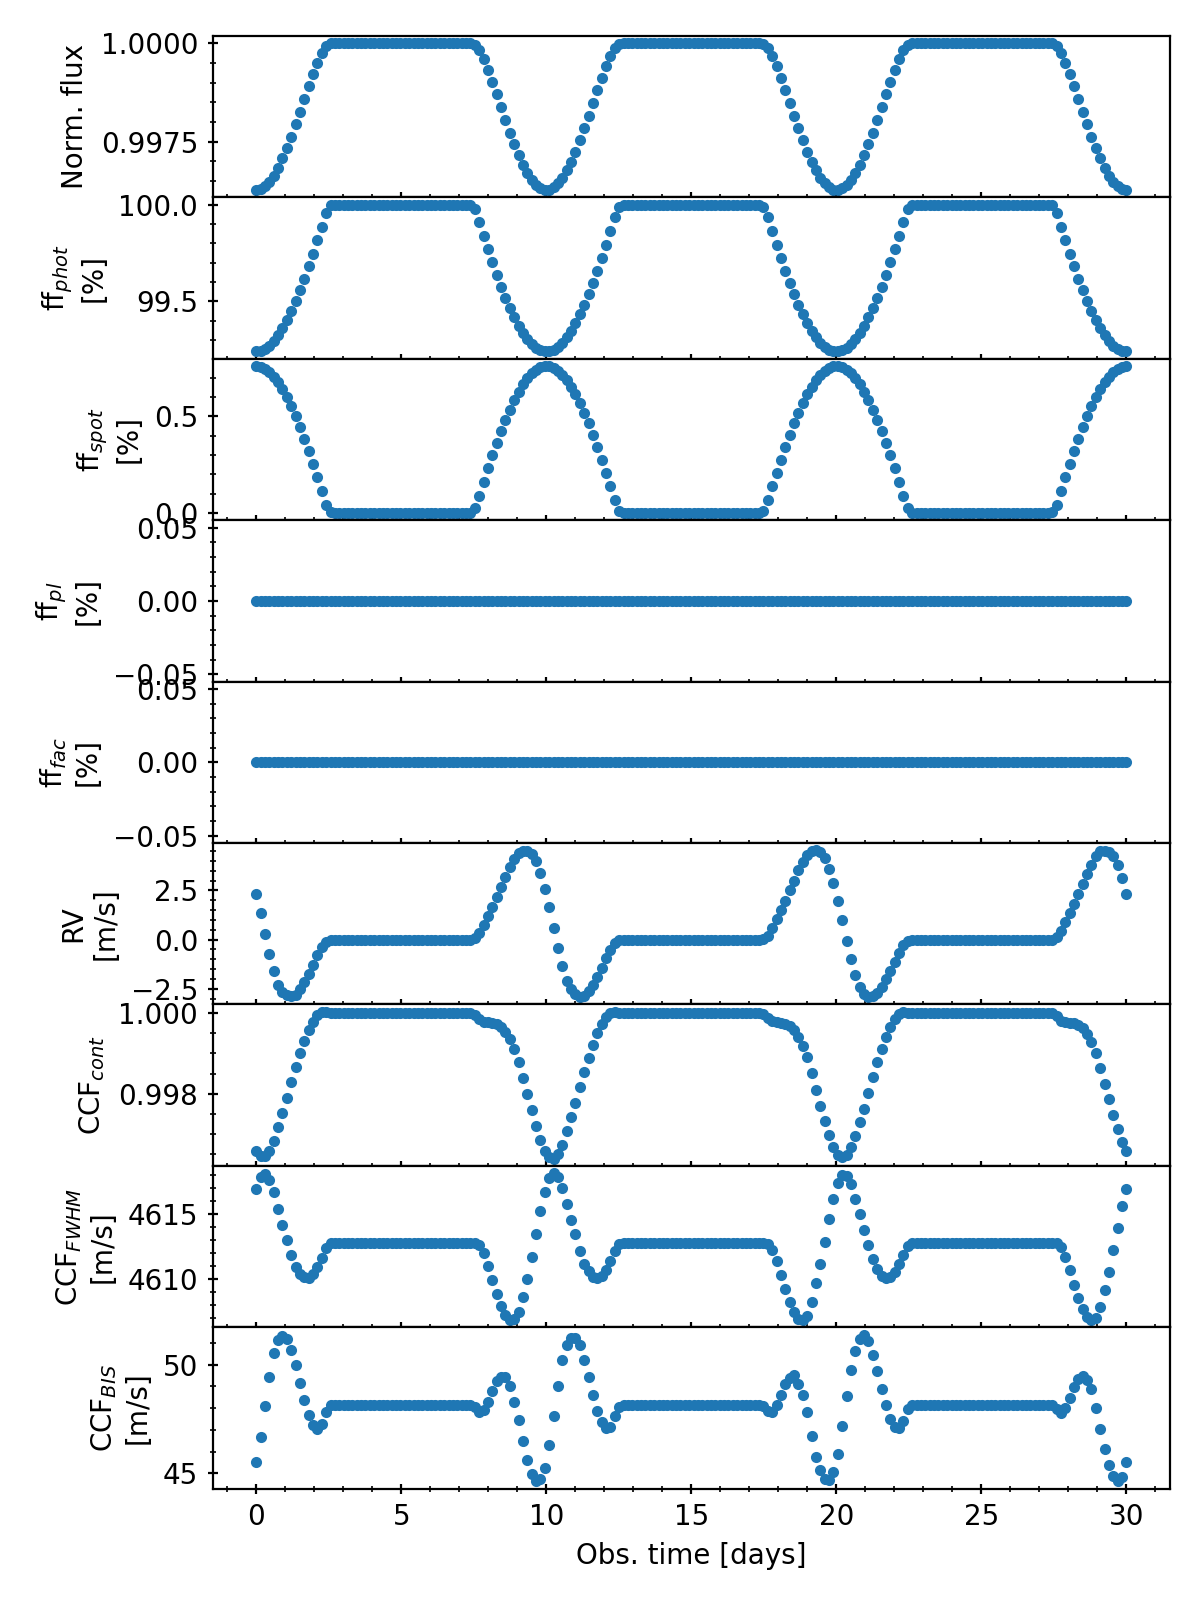

In [7]:
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

As you can se the figure contains subplots of more observable than the ones selected, such as the filling factors or all the CCF parameters. 

Note that even though we have set the rotation period to 2.5 with `ss.rotation_period=2.5`, the simulations show that the rotation period is still 10. Bear in mind that every time you define the ss object, it will read the starsim.conf file again and ignore all the changes made before, such as setting the period to 2.5.

### 5.1.- Introducing the chromatic indexs indicators

Starsim can also be tuned to work as an echelle spectrograph, computing the CCF parameters for each of the echelle orders containing a different wavelength range. This can be useful to simulate the dependence of the different parameters with the wavelength, which are called the chromatic indicators. To use this mode, one needs to generate a text file containing the number of order, the initial wavelength, and the final wavelength of a certain spectrograph, and store it in the folder _starsim/orders_CRX_. Lets run again the previous spot map adding the cromatic index and lot the results. Be aware that this mode will be much slower than with the 'lc' or 'rv' observables, since it has to repeat the simulation for each order (it should take ~1 minute). To simulate all the observables, you only need to set `observables=['lc','rv','crx']` as shown below:

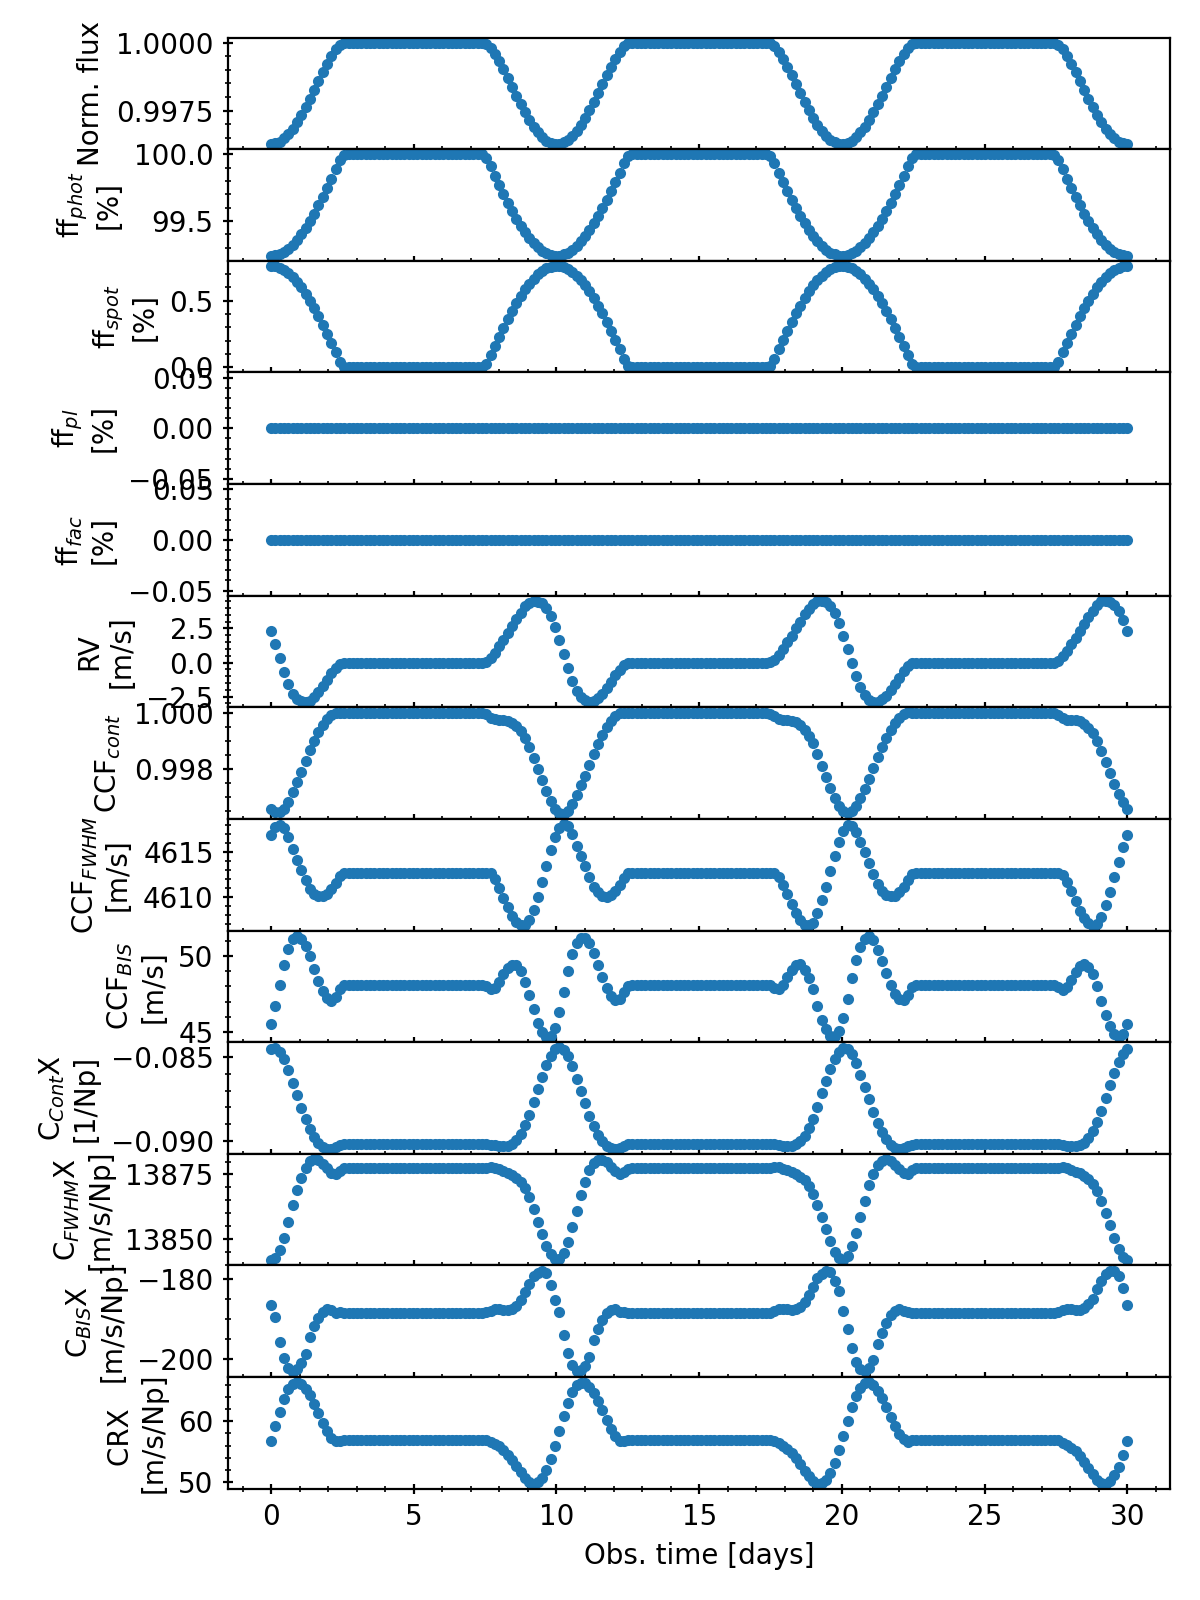

In [8]:
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling)
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

### 5.2.- Adding a planet

starsim can also simulate the effect of a transiting planet over the photometry, and all spectroscopic observables, including the rossiter-mclaughin effect and spot-crossing effects. To include a planet in the simulation, simply set _simulate_planet_ to 1 in starsim.conf, and run the forward model as before. We will reduce the simulated time to highlight the transit.

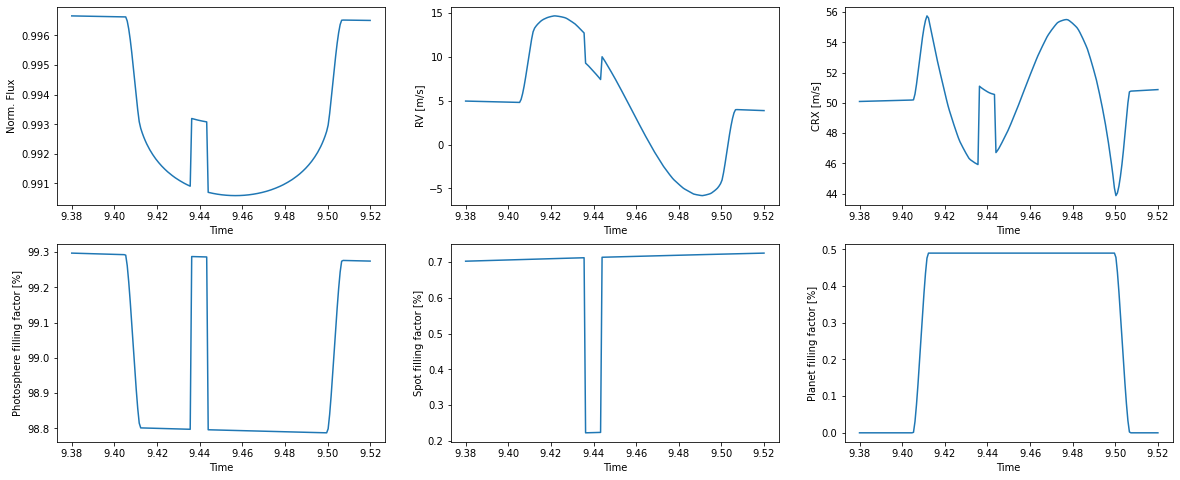

In [9]:
ss.simulate_planet=int(1) #Important to set it as an integer
t_sampling=np.linspace(9.38,9.52,200) #define the sampling time
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling) #simulate all observables

fig, ax = plt.subplots(2,3,figsize=(20,8))
ax[0,0].plot(t_sampling,ss.results['lc'])
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Norm. Flux')
ax[0,1].plot(t_sampling,ss.results['rv'])
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('RV [m/s]')
ax[0,2].plot(t_sampling,ss.results['crx'])
ax[0,2].set_xlabel('Time')
ax[0,2].set_ylabel('CRX [m/s]')
ax[1,0].plot(t_sampling,ss.results['ff_ph'])
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Photosphere filling factor [%]')
ax[1,1].plot(t_sampling,ss.results['ff_sp'])
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Spot filling factor [%]')
ax[1,2].plot(t_sampling,ss.results['ff_pl'])
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('Planet filling factor [%]')
plt.show()

As you can see in the plots, the transit stars at t=9.4, and there is a spot crossing event at t=9.44. This is reflected also in the filling factors.

Starsim not only simulates the drop in flux and the rossiter-Mclaughin effect, but also reproduces the effect over all other observables, such as the CRX. 

The spot crossing event produces a very sharp change in the observables, due to the lack of resolution in the overlapping between spot and planet. To avoid this, one should use the `precise` mode in starsim.cong with a very dense grid, but would be very time consuming to reproduce it here.

## 6.- Inverse mode

In the inverse model, the user provides any number of time-series of different observables, and starsim optimizes the spot map and/or the stellar parameters to match the observations. There are three main modes:

1. Compute N inversions with a given set of stellar parameters to obtain N spot maps. This is done with the method `best_maps, lnLs = ss.compute_inverseSA(N_inversions=N)` and returns the N best maps and log-likelihoods. Also returns the file `inversion_stats.npy` with the best maps and log-likelihoods. Uses the fast mode, so is not recommended for spots larger than ~20 deg.

2. Optimize the stellar parameters. Inside a user-defined range, starsim selects random stellar parameters, and for each set, computes the best spot map and the best likelihood. This method can be called with `ss.optimize_inversion_SA()` and as an output produces the file `inversion_MCMCSA_stats.npy` with the log-likehood, the stellar parameters and spot map of each step. Also recommended for spots larger than ~20deg.

3. Optimize stellar parameters and spot map simultaneously using an MCMC. This method treats the spot parameters as additional stellar parameters, and can be used in both fast and precise modes, so is recommended for stars with big spots or for cases with no more than 2-3 spots. It is executed with `ss.optimize_MCMC()`. The output consists of a plot with the MCMC chains, a corner plot with the results and a list with the optimized parameters and uncertainties. 

### 6.1.- Loading the time series

First of all let's create som dummy observables which we will invert. In this example we are going to use one RV curve and one light curve. To make it simpler, manually modify the `spotmap.dat` file to be:

0.0 40.0 90.0 30.0 5.0 0.0 0.0  0 0 1 1 1 0 0 

0.0 40.0 60.0 310.0 2.0 0.0 0.0  0 0 1 1 1 0 0

That is, two spots spot born at t=-1, with a lifetime of 40 days, at colatitudes of 90 and 60 deg, longitudes of 30 and 310 deg, and radii of 5 and 2 deg. The integers in the last 7 columns are used to fix (0) or optimize (1) the parameters of the first 7 columns. That is, here we will optimize the colatitude, longitude and spot size of both spots.

In [12]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
t_sampling=np.linspace(0,30,30) #sampling times
ss.compute_forward(observables=['lc','rv'],t=t_sampling) 

y_lc=ss.results['lc']
dy_lc=0.0001*np.ones(len(y_lc)) #Dummy errors
y_rv=ss.results['rv']
dy_rv=0.01*np.ones(len(y_rv)) #Dummy errors

Lets now load the data into starsim. It is done with the method `ss.load_data`, and it can read data from either a three-column text file using the argument filename, or from already defined python variables, as in this case.

In [13]:
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


Make sure that you specify the correct wavelength range and filter that the instrument is using. In this case we are using the same values as the specified in starsim.conf to run the forward model before, but may be different in your case.
Also, additional options to fit the data is given. If desired, you can add to the data a jitter term and an offset (multiplicative for the lc, fwhm and contrast observables, additive fr the others). Also, you can fix these parameters or let starsim optimize them at each inversion. In this case we are going to fix the offset.

The loaded data can be accesed with `ss.data['INSTRUMENT_NAME']['OBSERVABLE_NAME']`

### 6.2.- Inversion

Let's now invert this data and obtain 4 spot_maps. This can be parallelized, so make sure to use a convinient number of CPUs in the N_cpus option in starsim.conf or through ss.N_cpus. Remember that according to the spotmap file, we are optimizing the colatitude, longitude and size of a single spot. 

The execution of this line of code may take several minutes, but in your terminal it should show a progress bar and detailed information of the status of each inversion, with info about the step number, the acceptance fraction and the current best log-likelihood. In starsim.conf there is an option `N_iters_SA` to control the number of steps in each inversion. The default value is 7000, but can be increased to obtain better results or decreased to obtain faster results.

In [14]:
best_maps, lnLs = ss.compute_inverseSA(N_inversions=4)

Computing 4 inversions of 2 spots each.

Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv


100%|██████████| 4/4 [00:00<00:00, 924.36it/s]


 Step=6994/7000; Acc_frac=0.0665; lnL=241.973Inversion 2 complete with a lnL of 333.6428173077212
 Step=6999/7000; Acc_frac=0.0664; lnL=241.973Inversion 0 complete with a lnL of 241.9726483445224
 Step=6989/7000; Acc_frac=0.0668; lnL=273.413Inversion 1 complete with a lnL of 241.96296138038528
 Step=6999/7000; Acc_frac=0.0667; lnL=273.413Inversion 3 complete with a lnL of 273.4131942163162


The idea of repeating the inversion N times is to increase statistics, since in some cases the optimization may be trapped in a local maxima.
Once the inversion is finished, one can plot the resulting inverted time series with the funcion `ss.plot_inversion_results(best_maps,lnLs,Npoints=500)`, which plot the loaded data togther with the time series obtained by each inversion. The plots of the best spot maps at the desired time stamps are obtained with
`ss.plot_spot_map(best_maps,tref=[t1,t2,t3,...])`. The map of the active regions at each longitude and time is obtained with
`ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)`.

KeyboardInterrupt: 

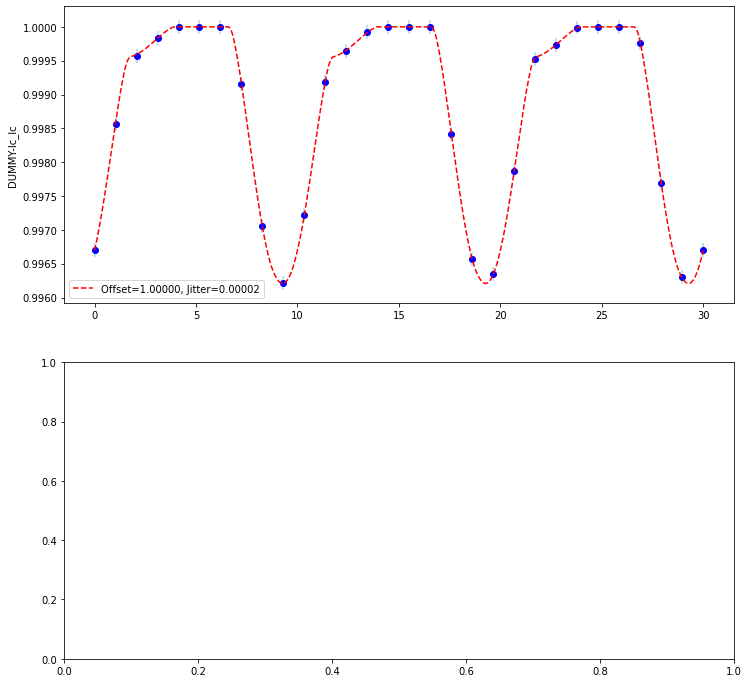

In [16]:
ss.plot_inversion_results(best_maps,lnLs,Npoints=500)
ss.plot_spot_map(best_maps,tref=[10,11])
ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)

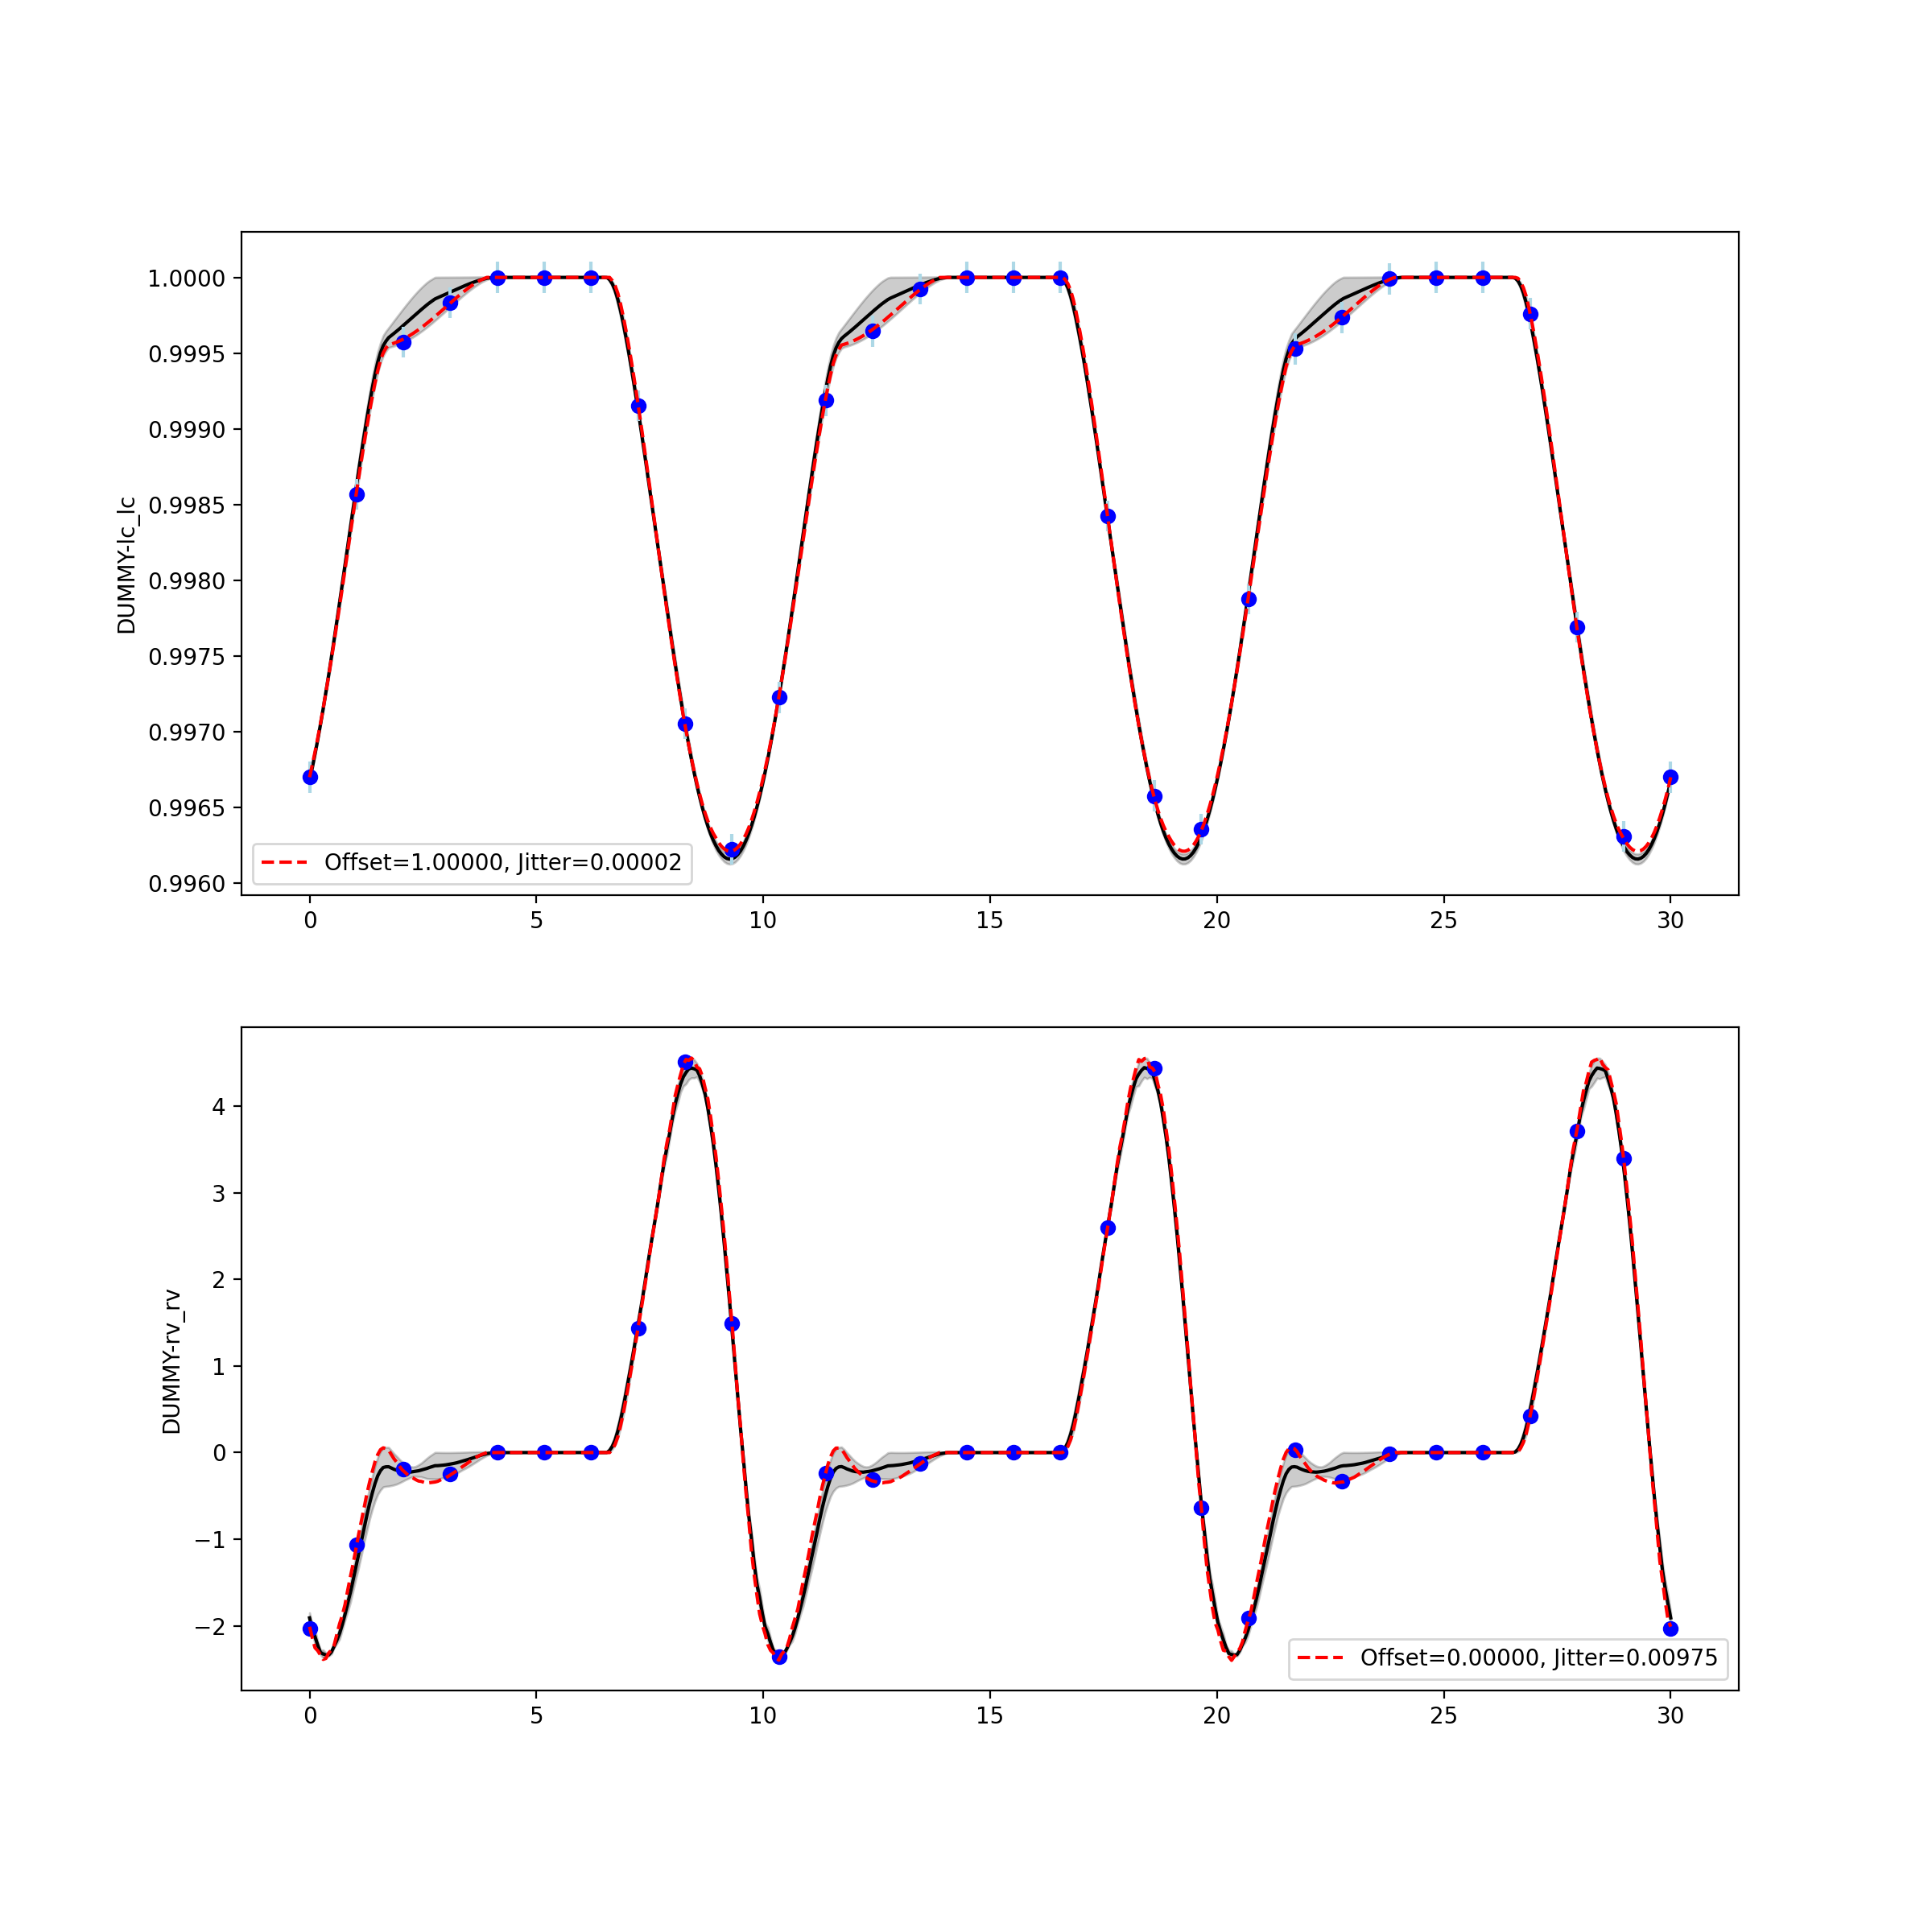

In [17]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=600) 

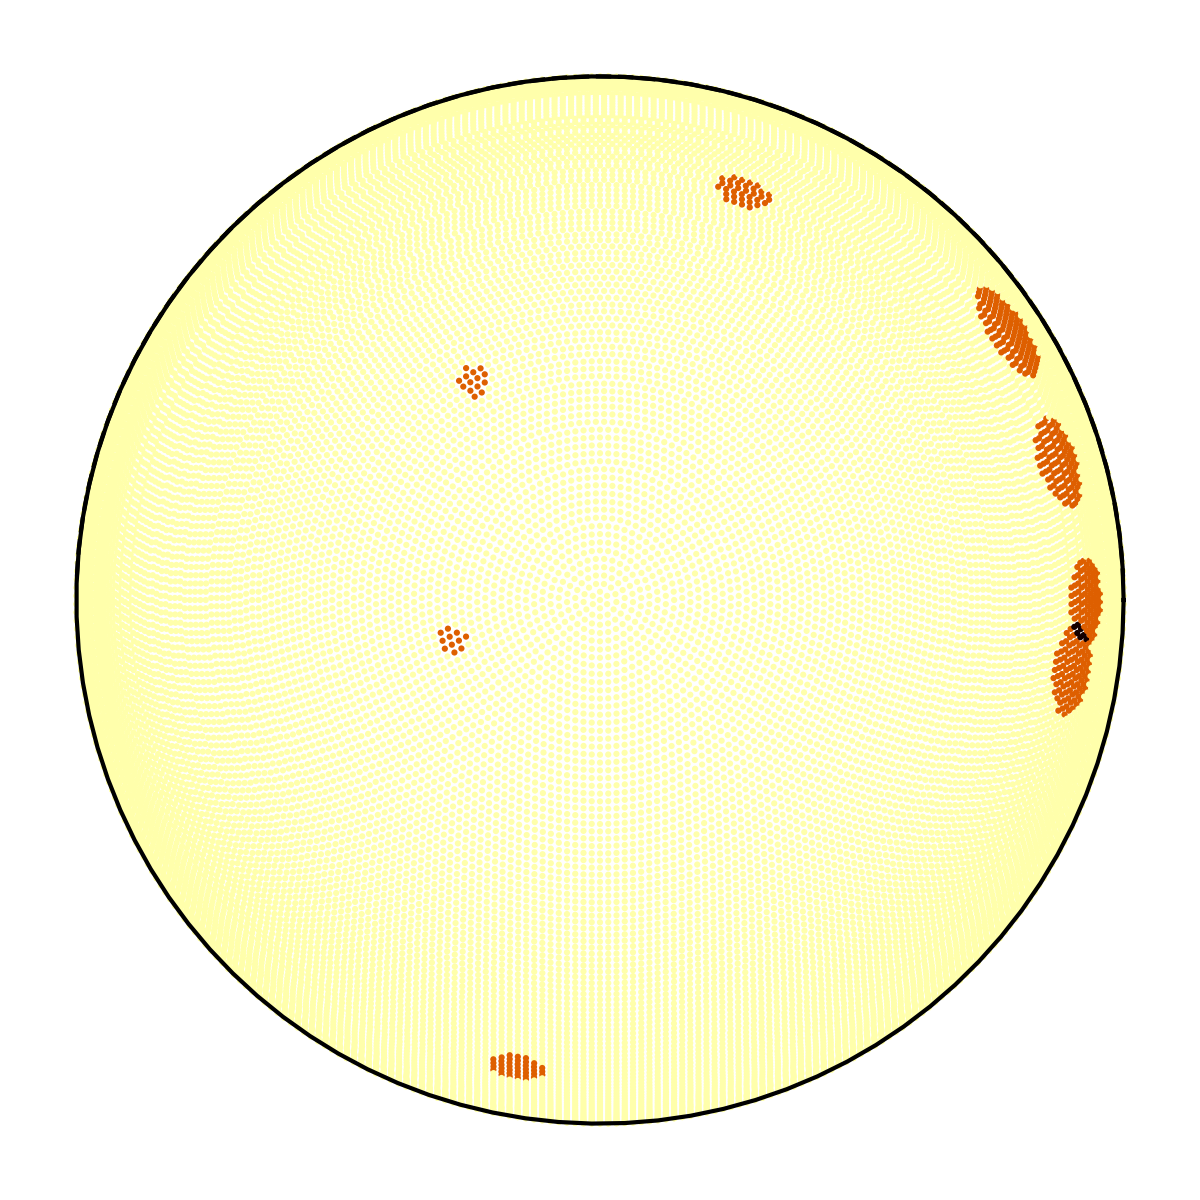

In [15]:
Image(filename='starsim/plots/inversion_spotmap_t_11.0000.png',width=400) 

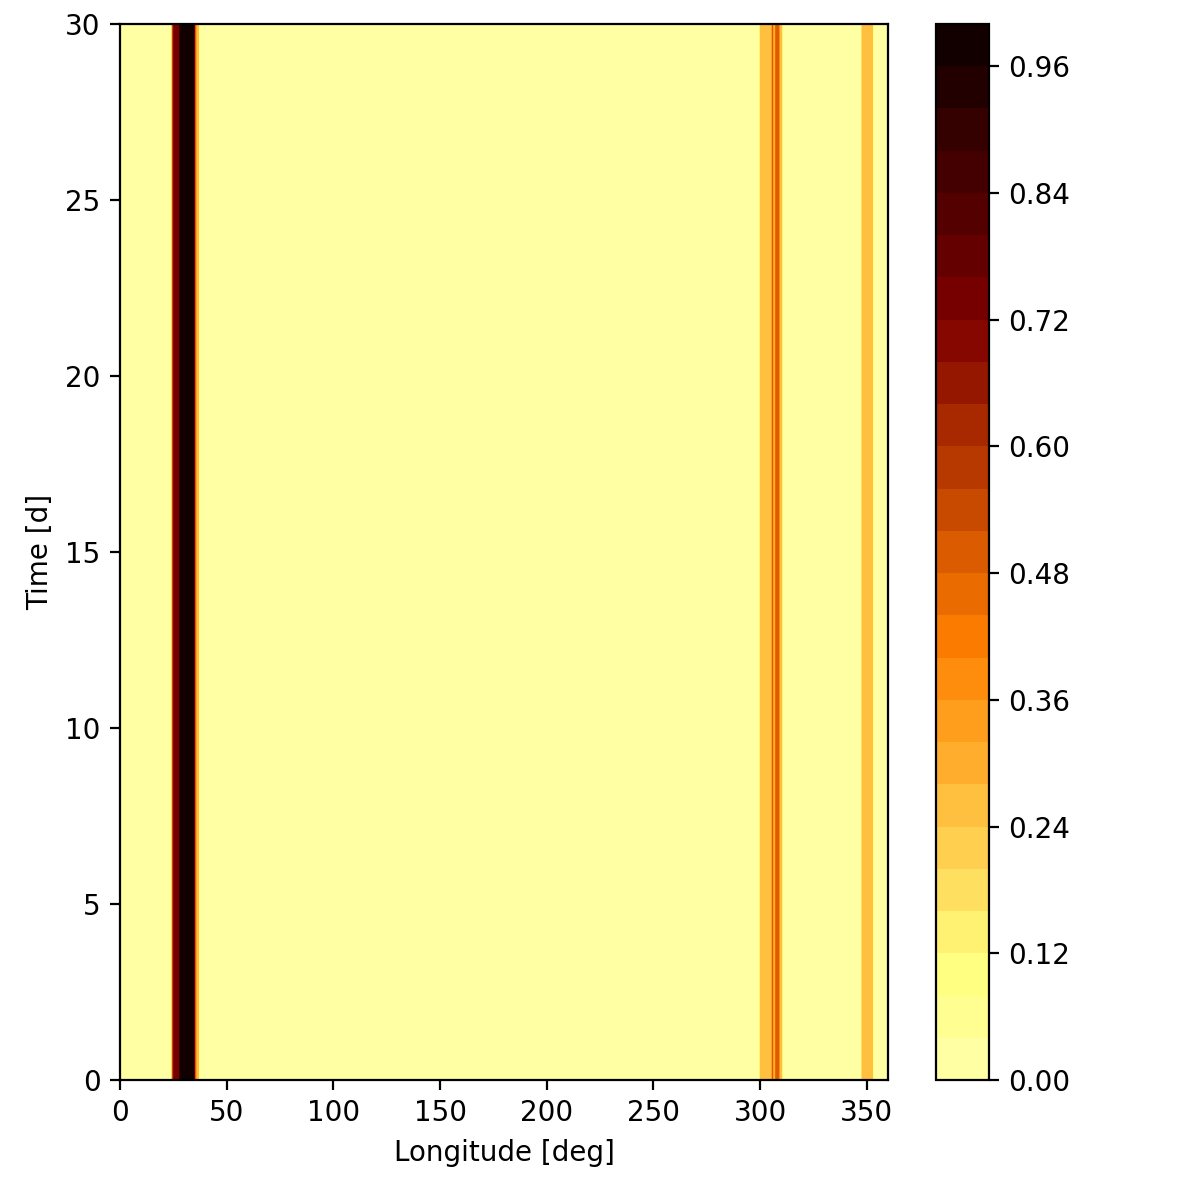

In [16]:
Image(filename='starsim/plots/active_map.png',width=400) 

### 6.3.- Stellar parameter optimization
The stellar parameters of the star can also be optimized by randomly exploring a grid of values and performing an inversion for each of those. This is an expensive routine, that may take several hours depending on the number of iterations you may want. We start by selecting in the configuration file `starsim.conf` the parameters that we want to optimize. Lets optimize the contrast temperature only. You should have something like this at line 88.

#stellar properties  
prior_t_eff_ph :              [0 , 3000 , 6000 , 0 , 4700 , 5500]    # Teff of the star photosphere (K)  
prior_spot_T_contrast :       [1 , 0 , 1000.0 , 0 , 0,500]    # Spot temperature contrast (K)  
prior_facula_T_contrast :     [0 , 0 , 100 , 0 , 0 , 100]    # Facula temperature contrast (K)  
prior_q_ratio :               [0 , 0 , 3 , 0 , 0 , 3]    # Facular to spotted area ratio Q  
prior_convective_blueshift:   [0 , -1 , 1.5 , 0 , -1 , 1.5]    # Convective shift factor.   
prior_p_rot :                 [1 , 9 , 11 , 0 , 9, 11]    # Rotation period (days)  
prior_inclination  :          [0 , 40 , 90, 0 , 40 , 90]    # Inclination of rotation axis (deg, 0 is pole on rotation)  
prior_stellar_radius :        [0 , 0.5, 1.5 , 0 , 0.5 , 1.5]    # Stellar radius (Rsun)  
prior_limb_darkening_q1 :     [0 , 0, 1, 0, 0.3, 0.5] #Limb darkening coefficient q1  
prior_limb_darkening_q2 :     [0 , 0, 1, 0, 0.05, 0.2] #Limb darkening coefficient q2 (don't fit if LD_law is linear)  
#planet  
prior_period_planet:           [0 , 1 , 15 , 0 , 2.77 , 2.78] #period of the planet (days)  
prior_time_transit_planet:	   [0 , 2457400.3 , 2457400.5 , 0 , 2457400 ,2457402.7]  #time of central transit (day)  
prior_semi_amplitude_planet:   [0 , 0 , 2000 , 0 , 120 , 130]  #RV semi-amplitude of panet (m/s)  
prior_esinw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1] #eccentricity times sine of arg. periastron  
prior_ecosw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1]  #eccentricity times cosine of arg. periastron  
prior_radius_planet:           [0 , 0.05 , 0.1 , 0 , 0 , 0.5] #Radius of planet (R*)  
prior_impact_parameter_planet: [0 , 0 , 1 , 0 , 0 , 1] #Impact parameter of the planet. b>1+Rp means no transit.  
prior_spin_orbit_planet:       [0 , 0 , 15 , 0 , 0 , 360]  # Spin-orbit angle of the transit chord (deg)  

Each line corresponds to a different stellar parameter. In brackets, there are 6 numbers: The first one is to optimize it (1) or leave it fixed (0). The second and third are the lower an upper limits where the optimization will be performed. **Make sure that the fixed parameters are within the specified limits, it will not throw an error but infinite log-likelihoods**. The third, fourth and fifth columns are the priors to generate the initial values. In this case we only optimize the spot contrast temperature, with an uniform prior between 0 and 500, and limits between 0 and 1000 (note that since we use an uniform prior there will be no values over 500, the limit is used with none uniform priors).

The last step is to select the number of random evaluations that we starsim will make. This is set with the parameter N_steps in `starsim.conf`. We set a small value of 8 only to sped up the process, but we recommend values larger than 1000 at least.

Before starting the optimization we should restart the ss object to apply the changes in starsim.conf.

In [17]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


And the optimization is started with:

In [18]:
ss.optimize_inversion_SA()


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
Searching random grid for best stellar parameters. Optimizing spotmap at each step.
Total parameters to optimize: 2


100%|██████████| 8/8 [00:00<00:00, 1338.16it/s]


[319.608  10.959] 123.32
[465.738  10.555] 146.90
[111.293   9.979] 216.03
[30.673  9.675] 133.05
[202.12    9.475] 135.48
[376.116   9.703] 160.10
[307.795  10.266] 184.01
[354.922  10.689] 136.70


Let's now print the results and plot some figures. It only takes solutions within DeltalnL of the best reusult. We recommend ussing DeltalnL<=15, since are comparable fits, but in this tutorial we use 100 since the number of realizations is really small.

In [19]:
ss.plot_optimize_inversion_SA_results(DeltalnL=100)

Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 313.70143+60.07197-192.36719
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  200.0 (fixed) 
	 	 P$_{{rot}}$ = 10.12258+0.55117-0.44475
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 -Mean and standard deviation:
	 	 $\Delta$ T$_{{sp}}$ = 313.70143+-135.89494
	 	 P$_{{rot}}$ = 10.12258+-0.50391
	 -Best solution, with maximum log-likelihood of 216.02861341900018
	 	 $\Delta$ T$_{{sp}}$ = 111.29339
	 	 P$_{{rot}}$ = 9.97944


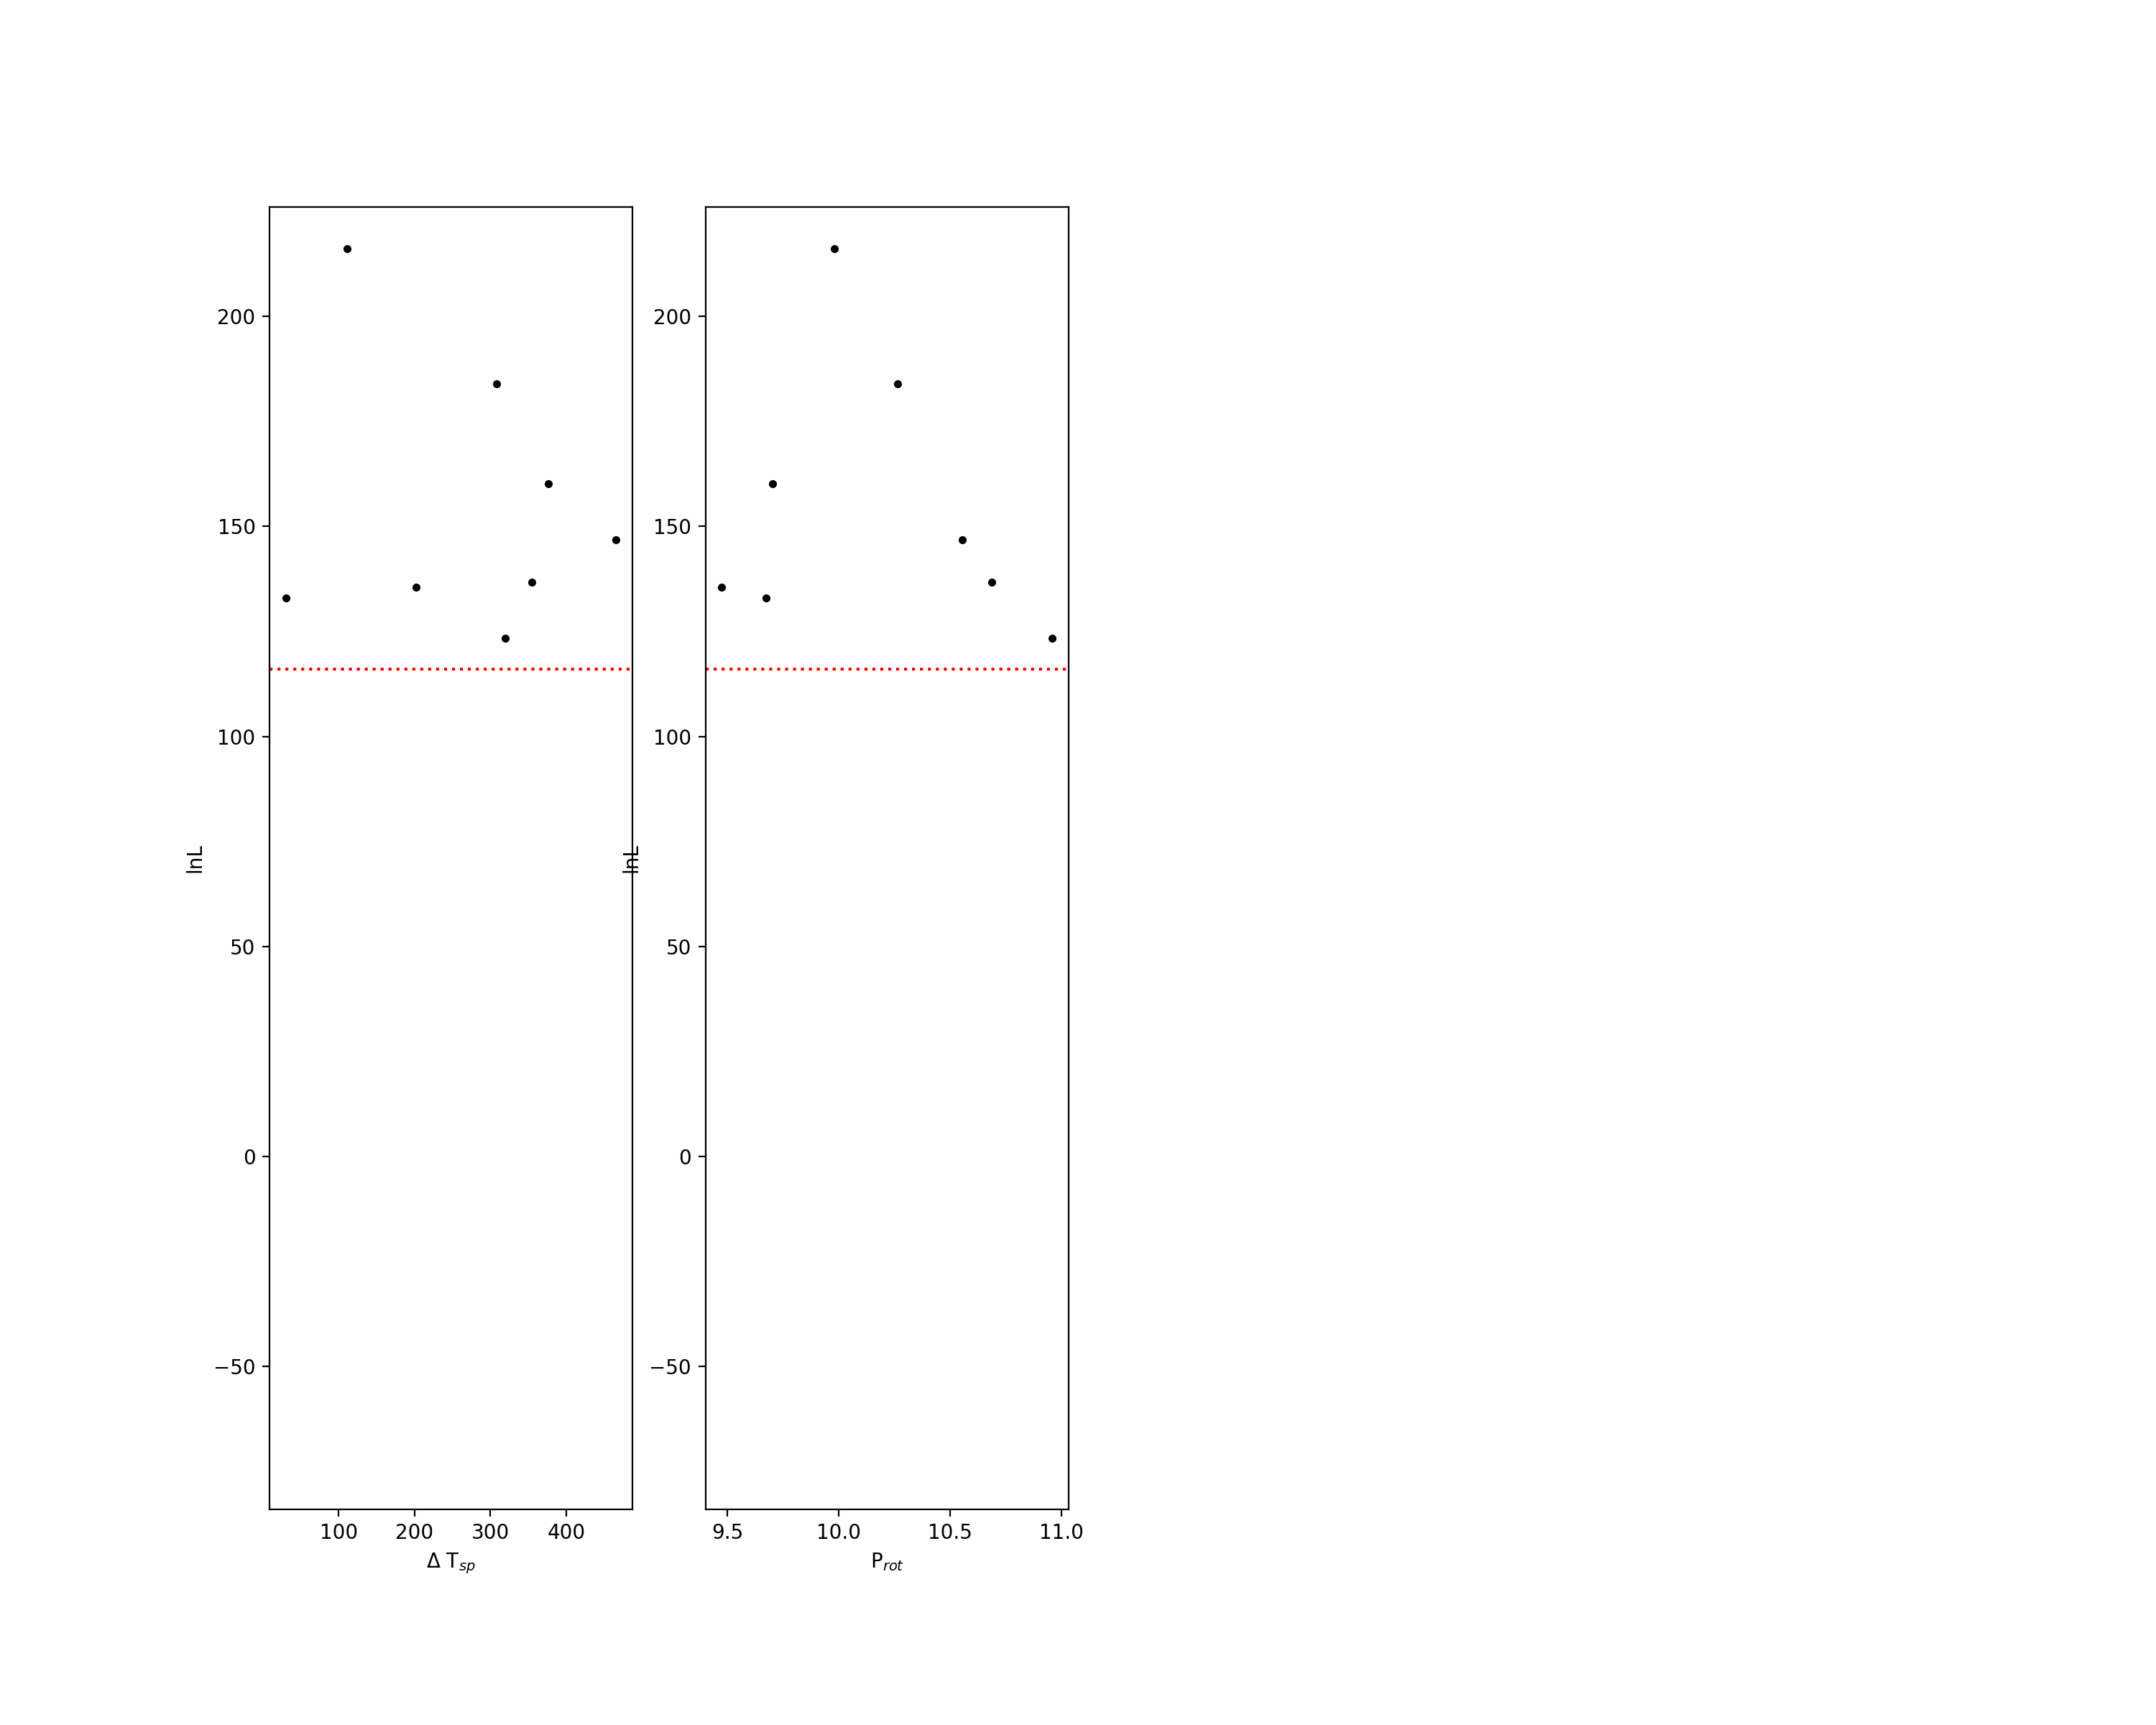

In [20]:
Image(filename='starsim/plots/inversion_MCMCSA_likelihoods.png',width=800) 

This plot the log-likelihoods of each evaluation. As you can see, rotation periods near 10 have the highest likelihoods. However, to obtain significant statistics we should perform much more iterations. The points above the red line are those within DeltalogL, which are selected for the next plots.

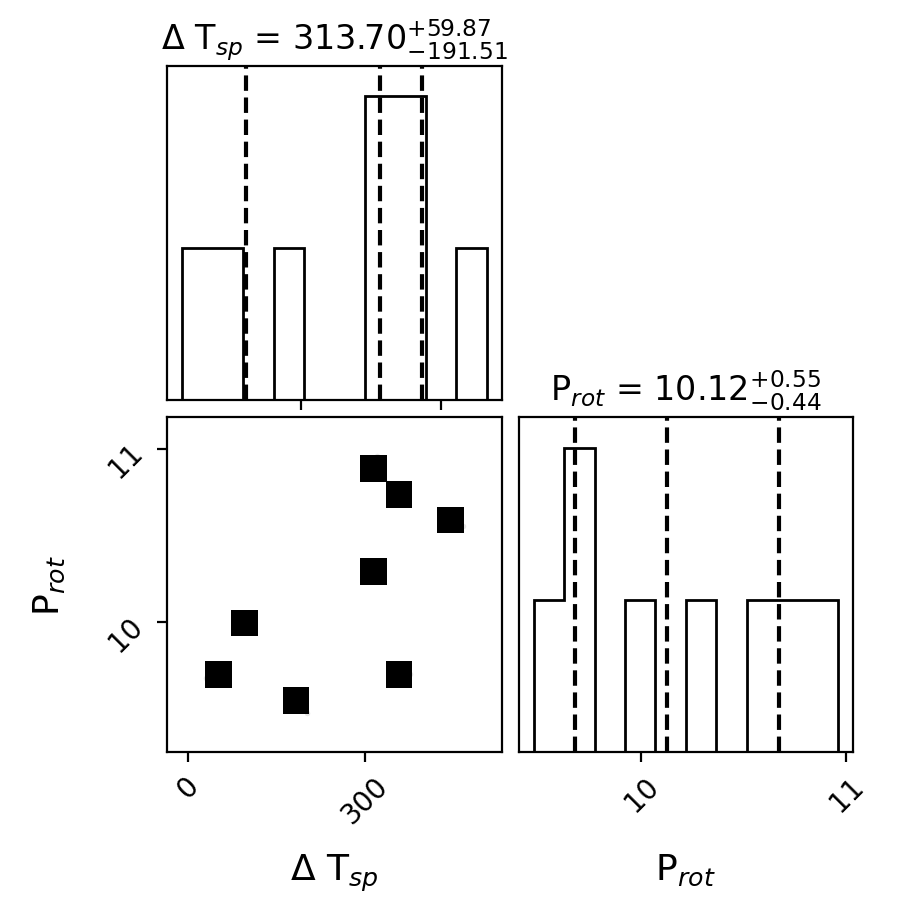

In [21]:
Image(filename='starsim/plots/inversion_MCMCSA_cornerplot.png',width=400) 

With more iterations, the histogram would aproach the input values. Finally, we plot the models of the solutions within DeltalnL.


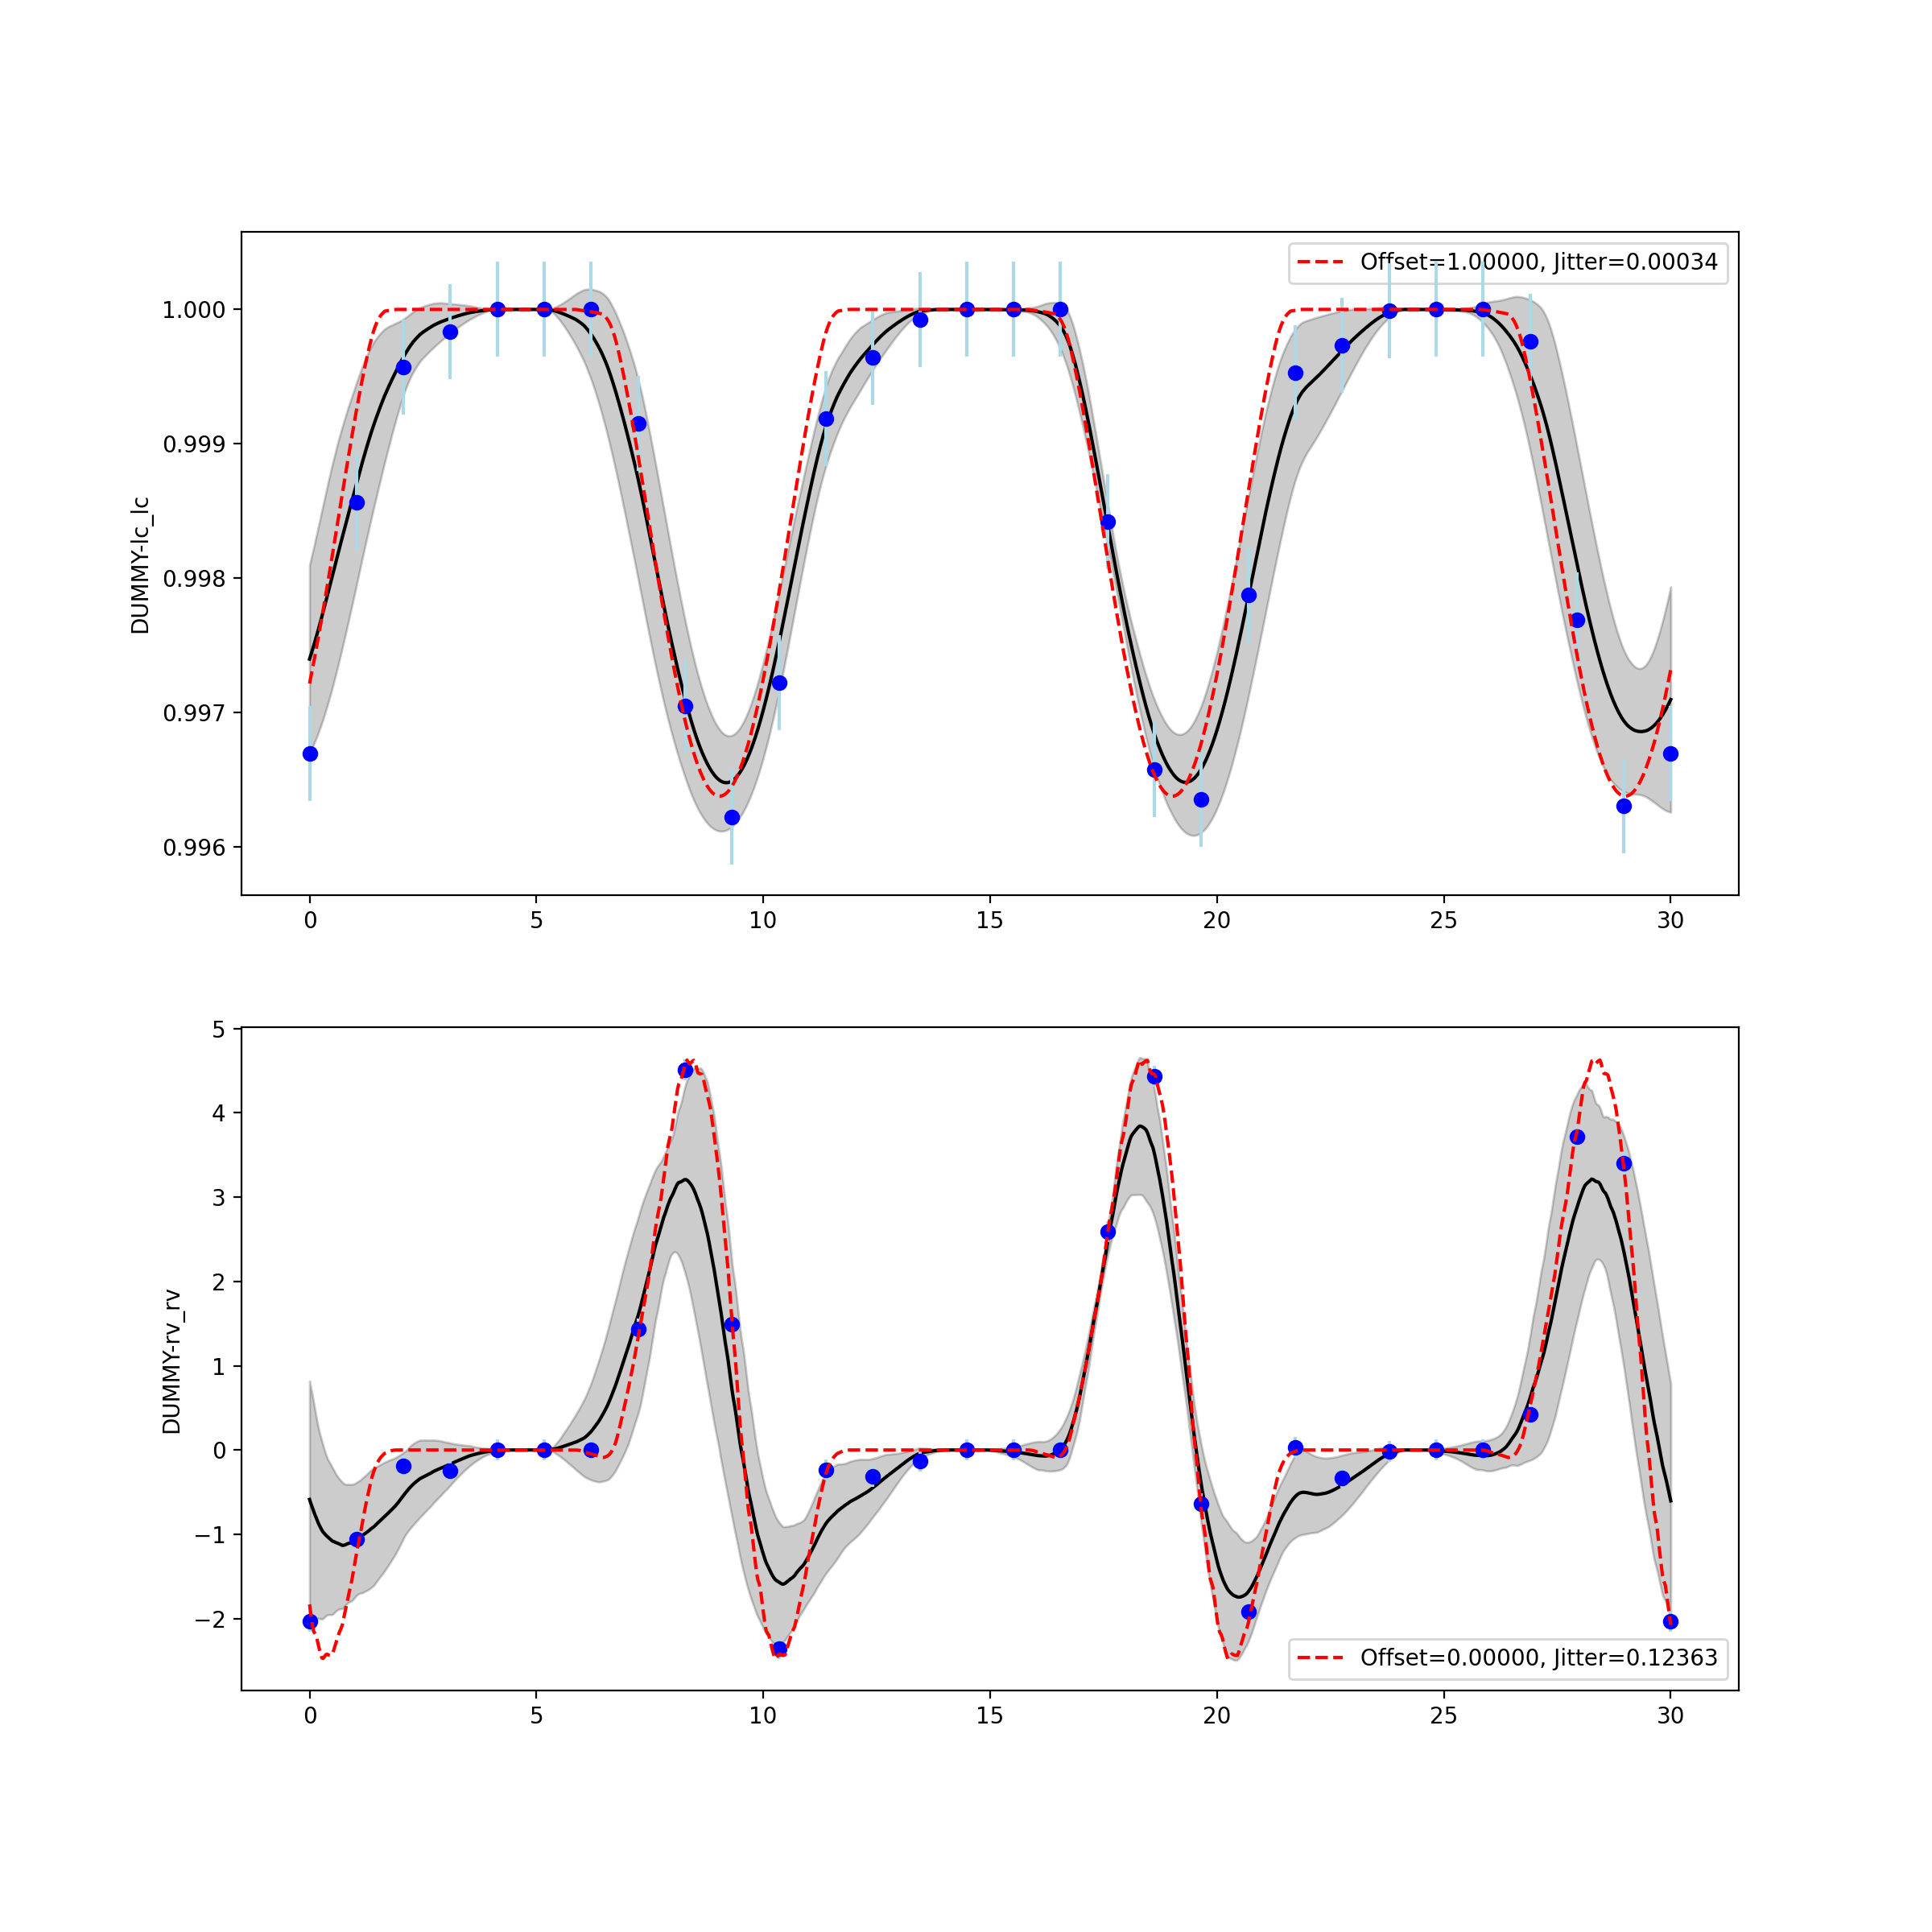

In [22]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=500) 

If you want to play with the results, they are saved in the file `inversion_MCMCSA_stats.npy`. To acces them simply do:

In [23]:
lnLs, params, best_map = np.load('starsim/results/inversion_MCMCSA_stats.npy',allow_pickle=True)

print('This is the best lnL:',np.max(lnLs))
print('These are the parameters of the best solution',params[np.argmax(lnLs)])
print('This is the best map of the best solution',best_map[np.argmax(lnLs)])

This is the best lnL: 216.02861341900018
These are the parameters of the best solution [3.50000000e+03 1.11293386e+02 3.00000000e+01 0.00000000e+00
 2.00000000e+02 9.97944465e+00 9.00000000e+01 5.00000000e-01
 4.30000000e-01 1.22000000e-01 9.32000000e-01 2.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 7.00000000e-02
 0.00000000e+00 0.00000000e+00]
This is the best map of the best solution [[  0.          40.         169.98342219  39.99149527   6.4066194
    0.           0.        ]
 [  0.          40.          70.72342688  33.39021197   6.34533695
    0.           0.        ]]


### Stellar parameter and spotmap optimization

In some cases when there is only one or two spots, or when the spots are too big for using the fast method (>~20 deg), there is a third option to invert the observed data using either the "fast" or the "precise" modes. This method uses an MCMC chain to simultaneously optimize stellar parameters and spot map. One should specify the number of burn-ins and the number of steps of the chain. Let's optimize now the contrast temperature, the period, and the six parameters of the spot map specified in the spotmap.dat file, with a burn-in length of 100 steps and an additional 100 steps after the burn-in. Once finished, the method will automatically print the results and generate a couple of plots. 


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
MCMC uncertainties estimation
Total parameters to optimize: 8
Running first burn-in...
[492.855  10.675   7.228  42.856  50.14   50.795   3.227   3.773] 0.0 112.82225922515974 112.82225922515974[486.353   9.649   3.859   3.523 268.229  54.226   3.703  21.419] 
0.0 39.28488098097938[405.239  10.942  16.873  41.975 187.388  55.378   9.972  16.68 ]  39.284880980979380.0 -35.36157721022923
 -35.36157721022923
[159.025   9.301  67.549  47.873  23.07  333.67    4.435   9.709] 0.0 53.22315454986206 53.22315454986206
[204.253  10.248  41.518  51.94  233.871  55.726  14.911   7.211] 0.0 -2.9868087408051593 -2.9868087408051593
[ 73.203  10.344  80.767  31.736   1.111 294.956  24.1    27.036] 0.0 -66.4978076678778 -66.4978076678778[322.565  10.937  61.864  25.579 217.573  19.499  27.939  24.81 ]
 0.0 -125.64431976290633 -125.64431976290633
[350.749   9.62   38.282   6.803 131.38  12

  0%|          | 0/2 [00:00<?, ?it/s]

[300.882  10.582  29.669  47.149 211.523  55.559  12.537  11.763] 0.0 1.2604589850519545 1.2604589850519545
[253.726   9.752  27.491  23.006  22.98  219.56    5.763  22.675] 0.0 -6.888763862114288 -6.888763862114288
[119.688   9.779  73.608  40.476  13.005 315.925  13.448  17.651] 0.0 -26.611725722356397 -26.611725722356397
[242.157  10.513  71.664  18.175 320.569 163.457  21.34   14.799] 0.0 -87.46547257301714 -87.46547257301714
[266.827   9.557  77.974  31.368 353.541  91.315  25.745  18.076] 0.0 -121.83459074534747 -121.83459074534747
[177.946   9.897  24.073  15.547 339.66  290.295  26.544  13.407] 0.0 -19.69316950314274 -19.69316950314274
[354.893  10.769  52.17   38.468 234.226  18.807  23.669  24.9  ][ 68.609  10.339  81.798  31.425  -3.135 299.787  24.333  27.344]  0.00.0  -67.52236253070825-108.08455005218721 -67.52236253070825
 -108.08455005218721
[199.269   9.908  57.934  25.222 239.767 275.002  19.755  25.295] 0.0 -79.31970085351483 -79.31970085351483[433.296  10.856  13.78

 50%|█████     | 1/2 [00:07<00:07,  7.96s/it]

[292.038   9.849  43.514  45.874  33.856 220.96    3.954   7.344][125.724  10.26   59.046  30.767 116.762 150.233   4.565  24.73 ] 0.0  0.053.544100499636684  -19.087994672301946 53.544100499636684
-19.087994672301946
[194.011   9.862  24.625  16.897 262.835 272.775  21.584  15.574] 0.0 -8.14841028788021 -8.14841028788021
[161.014  10.514  46.019  50.278 329.105  59.03   19.319  17.585] 0.0 -43.7239040044182 -43.7239040044182
[160.766  10.656  45.086  38.195  63.322 257.765  14.243  16.784] 0.0 -10.682242450474249 -10.682242450474249
[174.423  10.44   64.027  31.541 220.376 258.759   6.789  23.312] 0.0 -31.337704755215796 -31.337704755215796
[365.256  10.338  37.873  63.744 221.94   72.679  14.935  25.515] 0.0 -120.6514598350088 -120.6514598350088
[215.553   9.436  73.015  39.218 196.358 206.587  15.609  14.097] 0.0 -67.45996396241473[274.612  10.102  52.701  13.726 164.94  179.964  15.178  12.534]  -67.45996396241473
[377.072  10.201  51.488  62.641 240.245 303.692  13.976  20.705] 0.

100%|██████████| 2/2 [00:13<00:00,  6.95s/it]


Running second burn-in...
[521.653  10.461   5.508  48.493  44.085  68.935   3.736   3.167] 0.0 110.97652819980019 110.97652819980019
[508.149  10.443  20.854  35.406  -0.644  17.711   1.864   1.396] 0.0 88.84219074306105 88.84219074306105
[548.085  10.535   8.387  43.742 114.728  61.492   1.499   1.175] 0.0 88.45567446829611 88.45567446829611
[499.014  10.831   8.931  44.37   -8.41   58.441   3.49    5.696] 0.0 103.28178949867666 103.28178949867666
[431.733  10.494  26.08   39.108  92.09    5.793   0.029   6.204] 0.0 81.29058885884001 81.29058885884001
[460.075  10.744  13.917  44.631  49.414  42.164   3.919   0.684] 0.0 90.09554380502713 90.09554380502713
[527.601  10.601  13.442  46.262  38.487 133.296   3.39    2.809] 0.0 87.29880976351522 87.29880976351522
[490.011  10.582  13.455  46.668  93.87   82.522   1.675   3.272] 0.0 104.5081754631195 104.5081754631195
[560.89   10.757   7.649  45.55   56.186 108.48    3.843   5.443] 0.0 77.4368955185215 77.4368955185215
[491.095  10.611  

  0%|          | 0/2 [00:00<?, ?it/s]

[513.93   10.588  14.768  40.049  52.765 149.983   7.641   3.998] 0.0 90.62137953838443 90.62137953838443
[562.611  10.44   17.437  47.925  -9.877  95.011   5.882   0.661][434.384  10.671  18.197  32.896  22.256   2.608   3.763   1.433]  0.00.0 90.73646022593175  92.66148561060677 92.66148561060677
90.73646022593175
[471.768  10.87    5.43   40.872  86.115  44.686   8.436   8.441] 0.0 50.59199294697915 50.59199294697915[508.405  10.849   1.13   48.379  -3.195  90.261   1.522   6.29 ]
 0.0 76.25807495716786 76.25807495716786
[562.467  10.862   2.959  41.854  14.635 106.585   6.065   2.604][575.08   10.451   5.325  57.086  -2.582  85.442   0.588   5.944]  0.00.0  95.4951405989376 54.77403987315712 95.495140598937654.77403987315712



  0%|          | 0/8 [00:00<?, ?it/s]

Running production...
[416.246  10.81   10.798  44.157 116.77   67.419   3.573   3.309] 0.0 105.13537301904935[463.191  10.508  11.863  46.36   76.235  71.338   4.991   1.832] 105.13537301904935 
0.0 96.12869247818062 96.12869247818062
[471.79   10.672   8.839  34.8   133.847   6.513   0.238   1.634] 0.0[524.722  10.506  19.17   33.348  -3.471 111.42    7.754   2.881]  0.086.96407241065374  86.9640724106537495.87927033488461
 95.87927033488461


 38%|███▊      | 3/8 [00:03<00:05,  1.01s/it]

[509.522  10.889   1.877  39.375  99.827  73.332   9.969   6.601] 0.0 89.83213418755042 89.83213418755042
[442.892  10.419   9.164  50.163  38.565  50.565   3.347   2.761] 0.0 108.39742400899345 108.39742400899345
[461.01   10.896  19.785  34.627  91.227   4.224   4.667   5.596] 0.0 91.4145599976749 91.4145599976749
[484.69   10.305  29.374  30.217  56.327  80.095   5.694   3.183] 0.0 123.99799907922215 123.99799907922215
[567.432  10.654  14.704  55.098  -9.833  76.274   1.722   3.922] 0.0 122.07439002307557 122.07439002307557
[614.639  10.846   8.989  40.456  23.915  96.976   4.664   1.54 ] 0.0 92.16756418340239 92.16756418340239
[487.356  10.356   5.587  46.264 165.004  44.271   0.183   1.389] 0.0 90.12665533603618 90.12665533603618


 50%|█████     | 4/8 [00:08<00:10,  2.61s/it]

[454.001  10.828   7.245  42.66  130.482  96.065   5.105   1.47 ] 0.0 88.24537160276046 88.24537160276046
[408.435  10.559   1.532  40.808 103.813  48.815   8.254   4.356] 0.0 122.60727128696311 122.60727128696311
[403.102  10.471   7.337  36.574  29.745  29.14    5.896   0.694] [446.916  10.177  30.574  27.147 110.491  85.837   1.133   5.617]0.0  0.089.3936109869637 [506.979  10.925  16.101  47.185  50.323  22.255   0.999   6.858]  88.9000849675551989.39361098696370.0  88.90008496755519
55.083974664873665 
55.083974664873665
[500.703  10.33   14.764  39.071  39.604 102.767   0.437   1.913] 0.0[565.977  10.494   7.367  51.555  39.788 122.313   3.731   3.632]  86.761360644545870.0  86.7613606445458779.7402659437724
 79.7402659437724
[537.315  10.541  26.696  31.275  12.964   3.826   8.325   2.796] 0.0 71.33635643877489 71.33635643877489


 62%|██████▎   | 5/8 [00:14<00:10,  3.42s/it]

[445.852  10.208  33.776  22.789  56.218  68.465   3.734   2.16 ] 0.0 108.13631401312128 108.13631401312128
[604.722  10.938  15.096  35.137  15.422 108.386   7.696   4.268] 0.0 111.96150711340235 111.96150711340235
[463.026  10.891  11.857  47.306  42.266 113.854   5.684   4.644] 0.0 97.69026284039629 97.69026284039629
[411.331  10.407  13.598  42.664  36.754  10.894   1.404   1.054] 0.0 87.26230514570103 87.26230514570103
[518.34   10.62   20.578  26.012  50.316 116.419   4.666   0.916] 0.0 99.2826938678775 99.2826938678775
[458.142  10.769  21.412  30.359  91.201  15.372   7.143   3.656] 0.0 119.1978478299267 119.1978478299267


 75%|███████▌  | 6/8 [00:18<00:07,  3.80s/it]

[545.382  10.484  16.656  47.482   5.031  91.763   5.61    0.973] 0.0[476.286  10.775  12.189  40.335   2.374  38.807   3.586   4.197]  0.095.72885894139908  104.6992422841125795.72885894139908 
104.69924228411257
[558.472  10.645  12.791  53.923  -3.424  76.383   1.932   3.994] 0.0 122.0018185022476 122.0018185022476
[509.967  10.85    1.356  48.164  -2.893  90.555   1.622   6.257] 0.0 77.11903608004914 77.11903608004914
[588.71   10.335   9.577  56.459  15.612 142.035   1.22    2.437] 0.0 80.54252280951017[420.58   10.793   1.624  44.38   79.295  16.464   2.748   3.008]  80.542522809510170.0 
91.43233647576605 91.43233647576605
[484.613  10.703  21.045  28.448  73.223  59.805   6.053   2.451] 0.0 113.94905311004243 113.94905311004243
[447.859  10.692  17.952  33.073  21.715  10.976   4.074   1.657] 0.0 [469.038  10.357  23.659  32.391  66.074  73.674   6.22    3.424]91.82991979796014  91.829919797960140.0
 115.20165282427956 115.20165282427956
[272.4    10.712   7.518  51.042 194.119

100%|██████████| 8/8 [00:24<00:00,  3.10s/it]


Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 490.01141+72.59971-58.48510
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  200.0 (fixed) 
	 	 P$_{{rot}}$ = 10.60390+0.25845-0.16372
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 	 spot_0_it  =  0.0 (fixed) 
	 	 spot_1_it  =  0.0 (fixed) 
	 	 spot_0_lt  =  40.0 (fixed) 
	 	 spot_1_lt  =  40.0 (fixed) 
	 	 spot_0_lat = 7.87671+11.07449-6.69600
	 	 spot_1_lat = 44.37049+5.78616-7.09234
	 	 spot_0_lon = 52.76486+50.14977-55.95948
	 	 spot_1_lon = 73.33204+22.34622-67.53905
	 	 spot_0_c1 = 3.57257+2.49235-3.54392

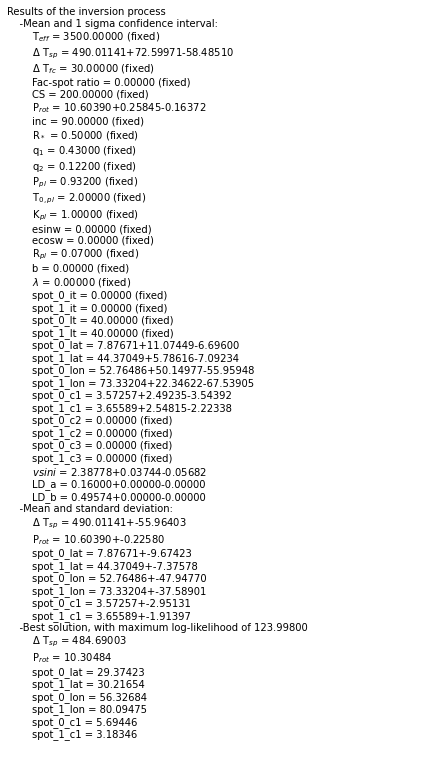

In [24]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)

ss.optimize_MCMC()

In [25]:
ss.plot_MCMCoptimization_chain()
ss.plot_MCMCoptimization_likelihoods()
ss.plot_MCMCoptimization_corner()
ss.plot_MCMCoptimization_best_results(t=np.linspace(t_sampling[0],t_sampling[-1],200),fold=False)
#ss.plot_MCMCoptimization_results(t=np.linspace(t_sampling[0],t_sampling[-1],200))


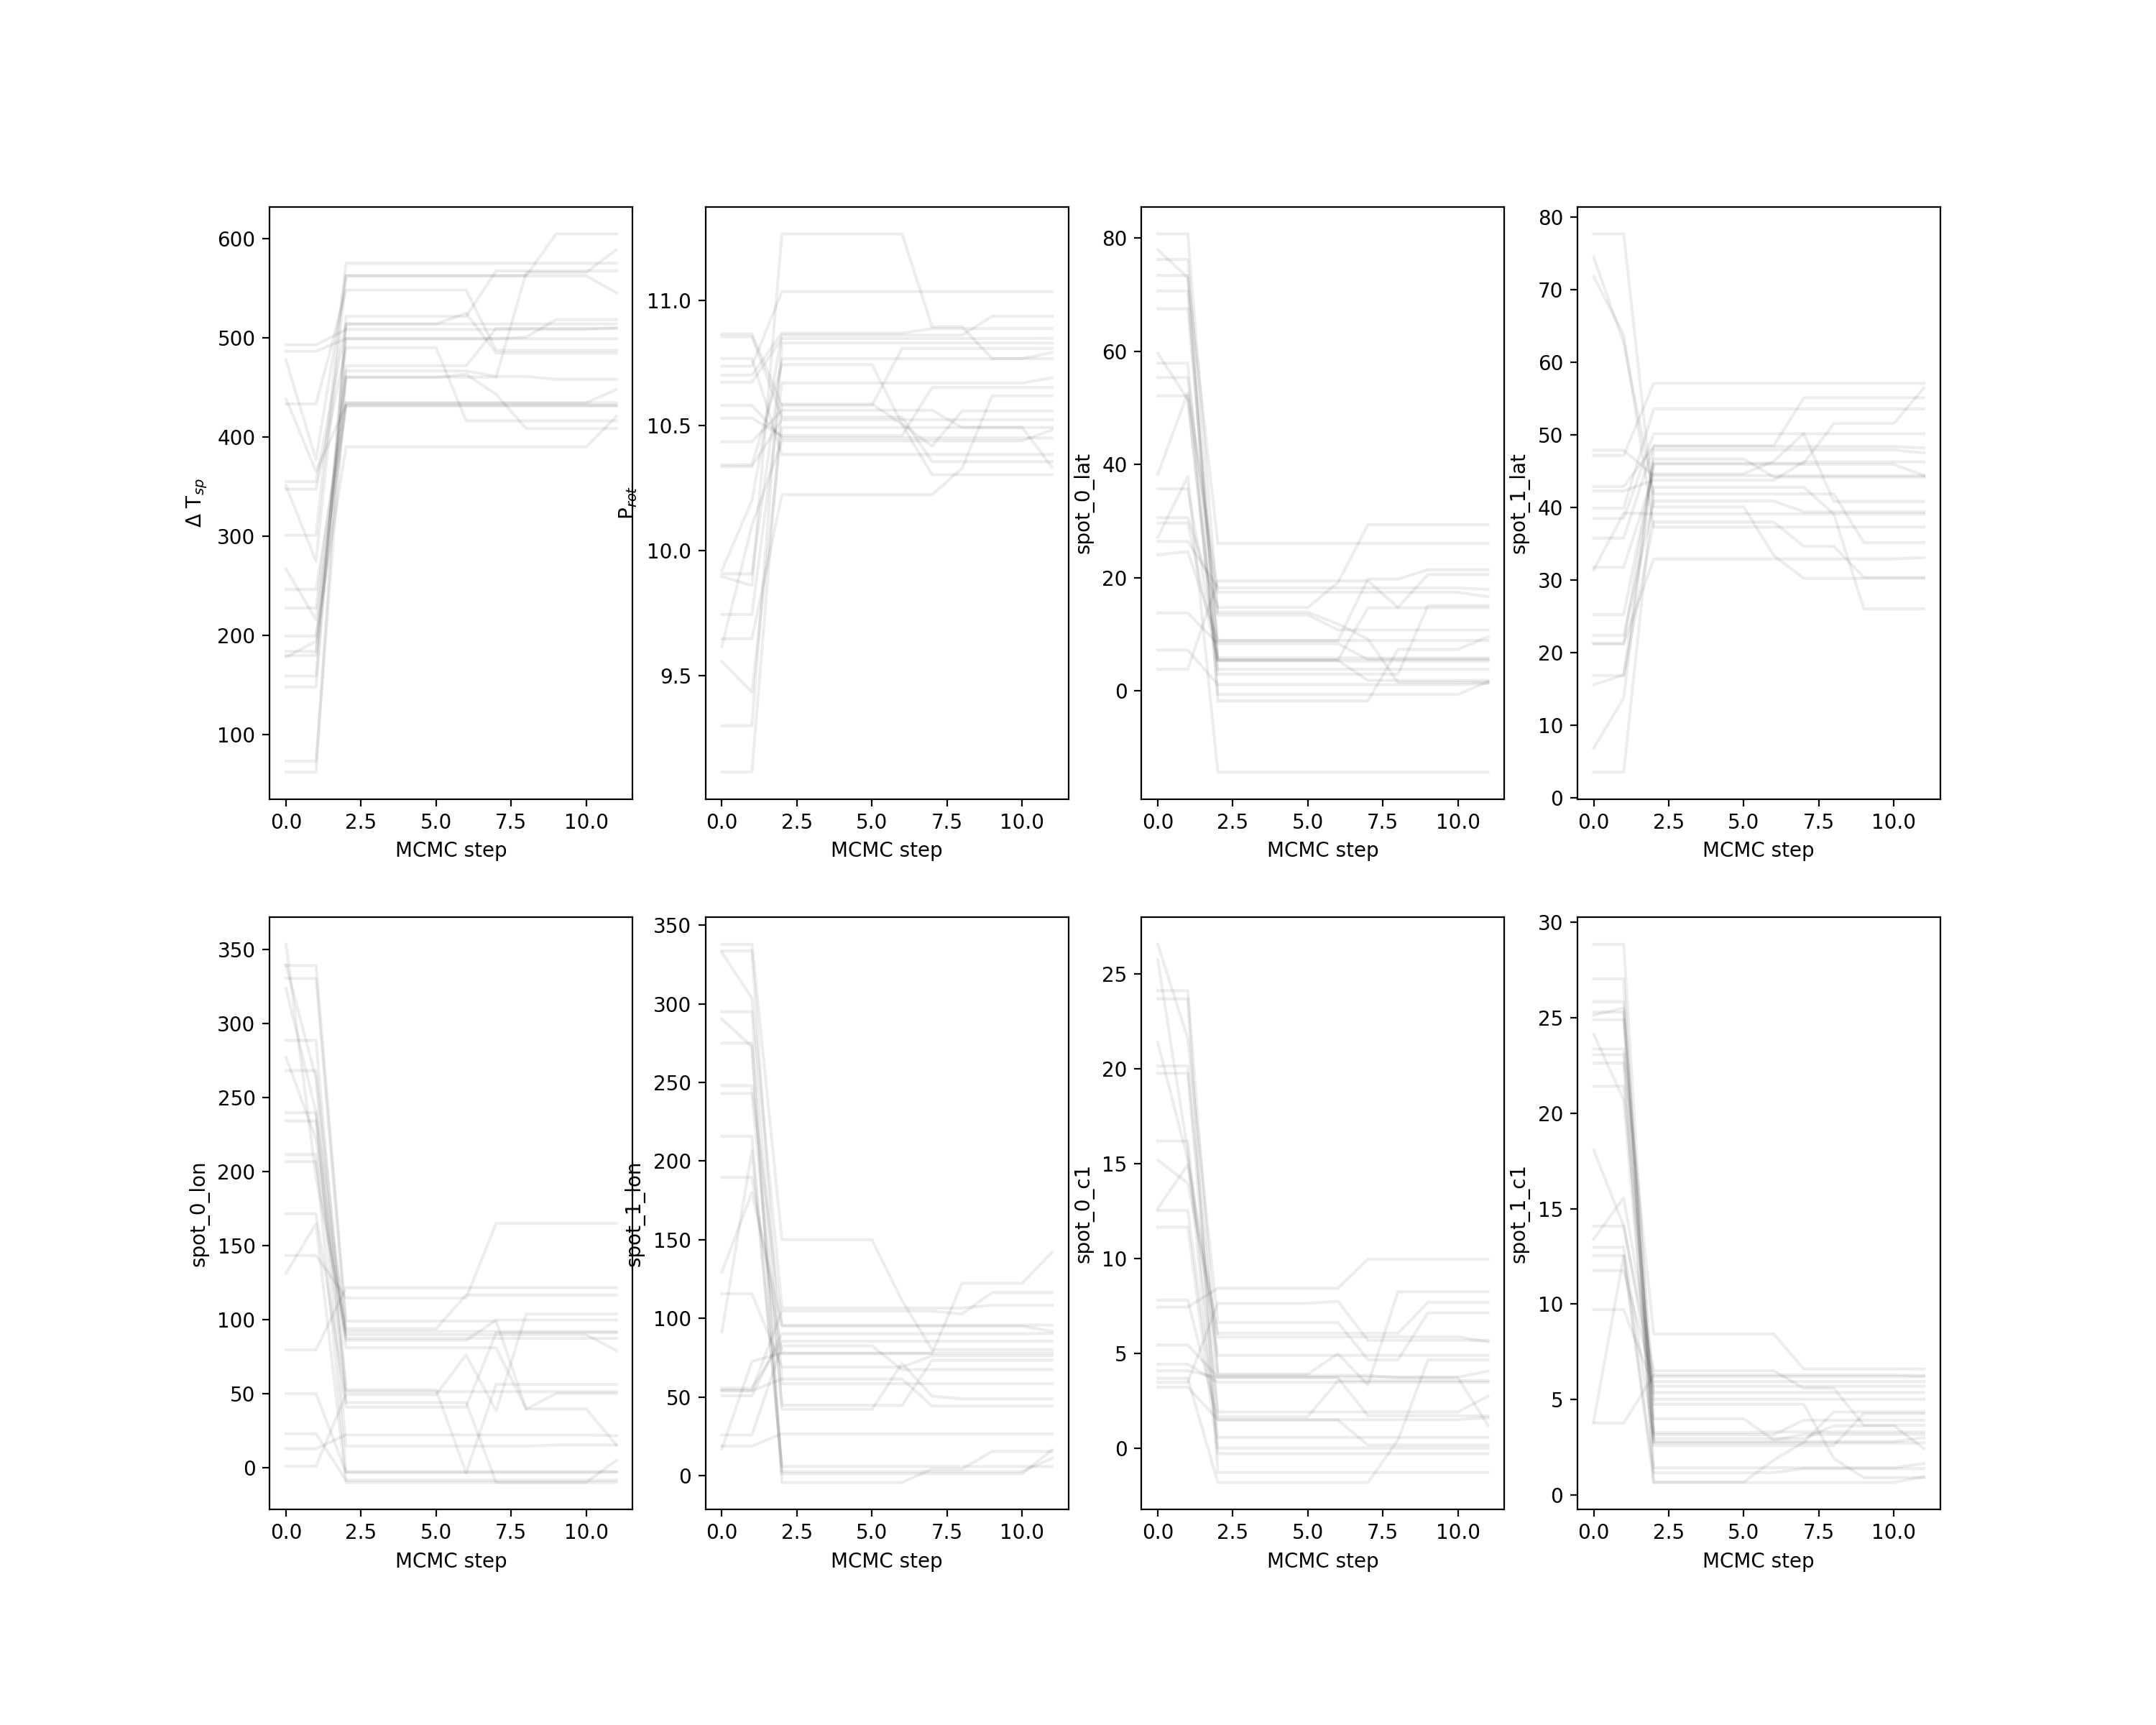

In [26]:
Image(filename='starsim/plots/MCMCoptimization_chains.png',width=800) 

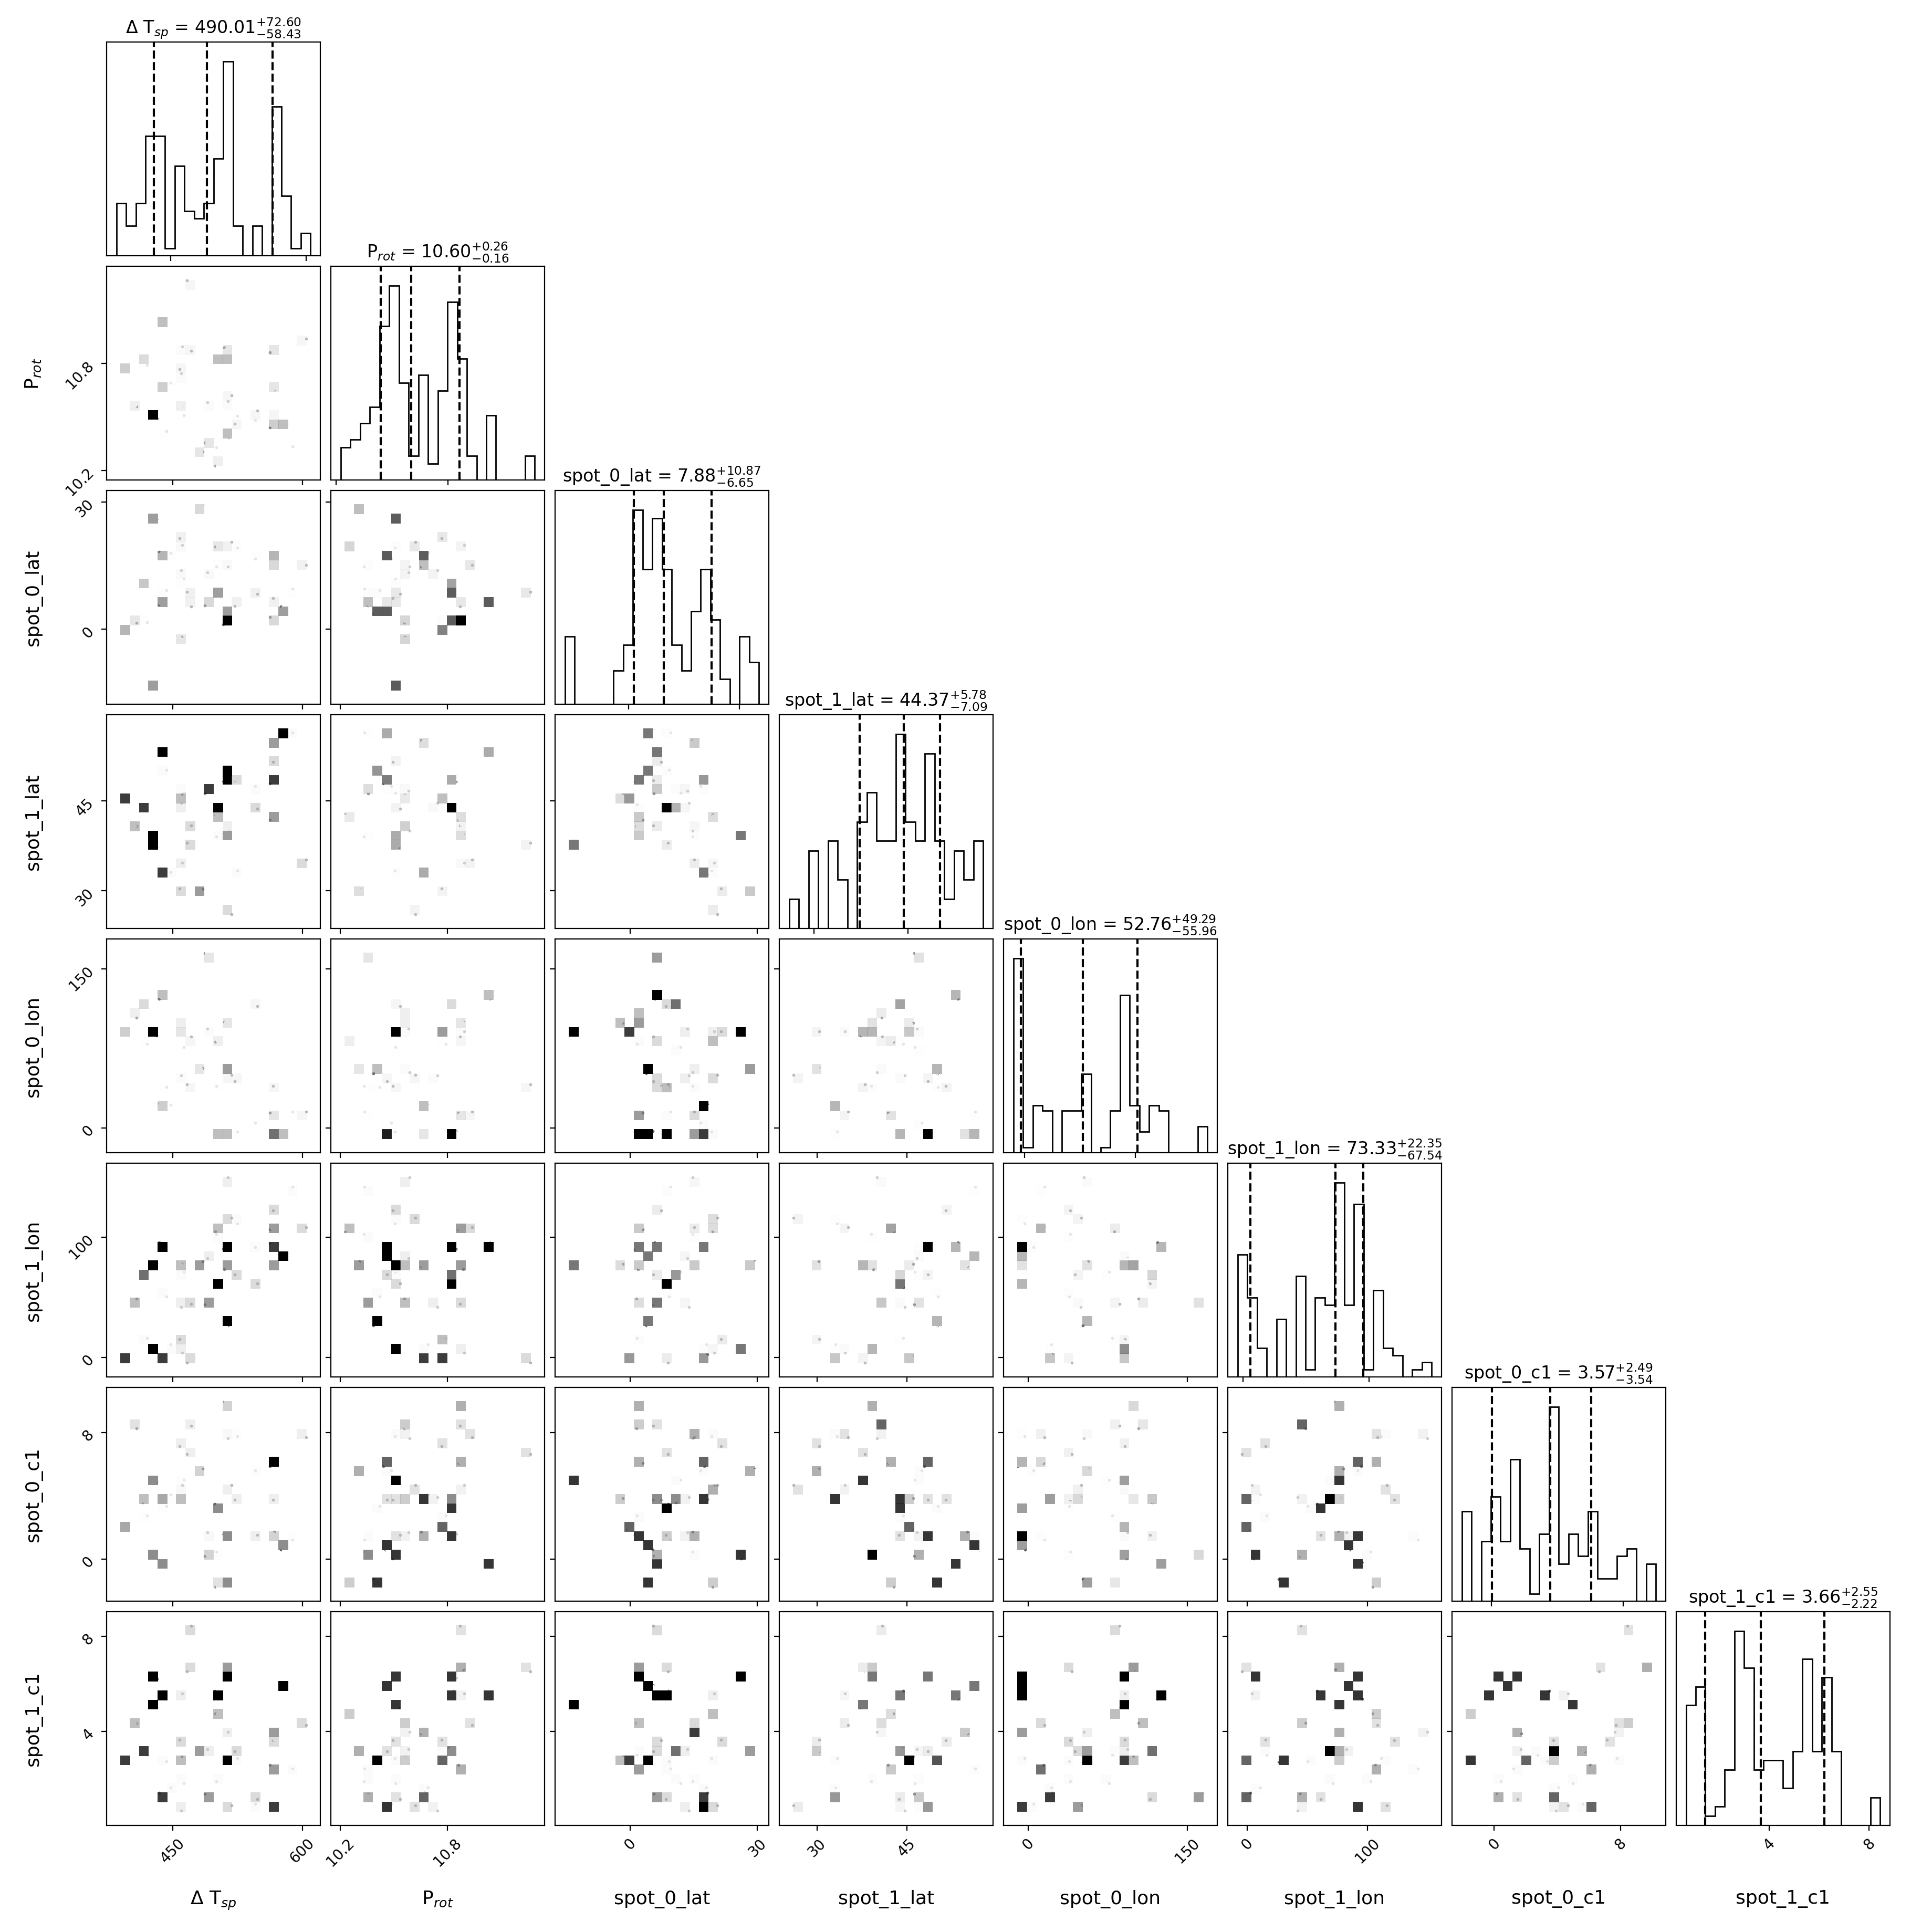

In [27]:
Image(filename='starsim/plots/MCMCoptimization_cornerplot.png',width=500) 

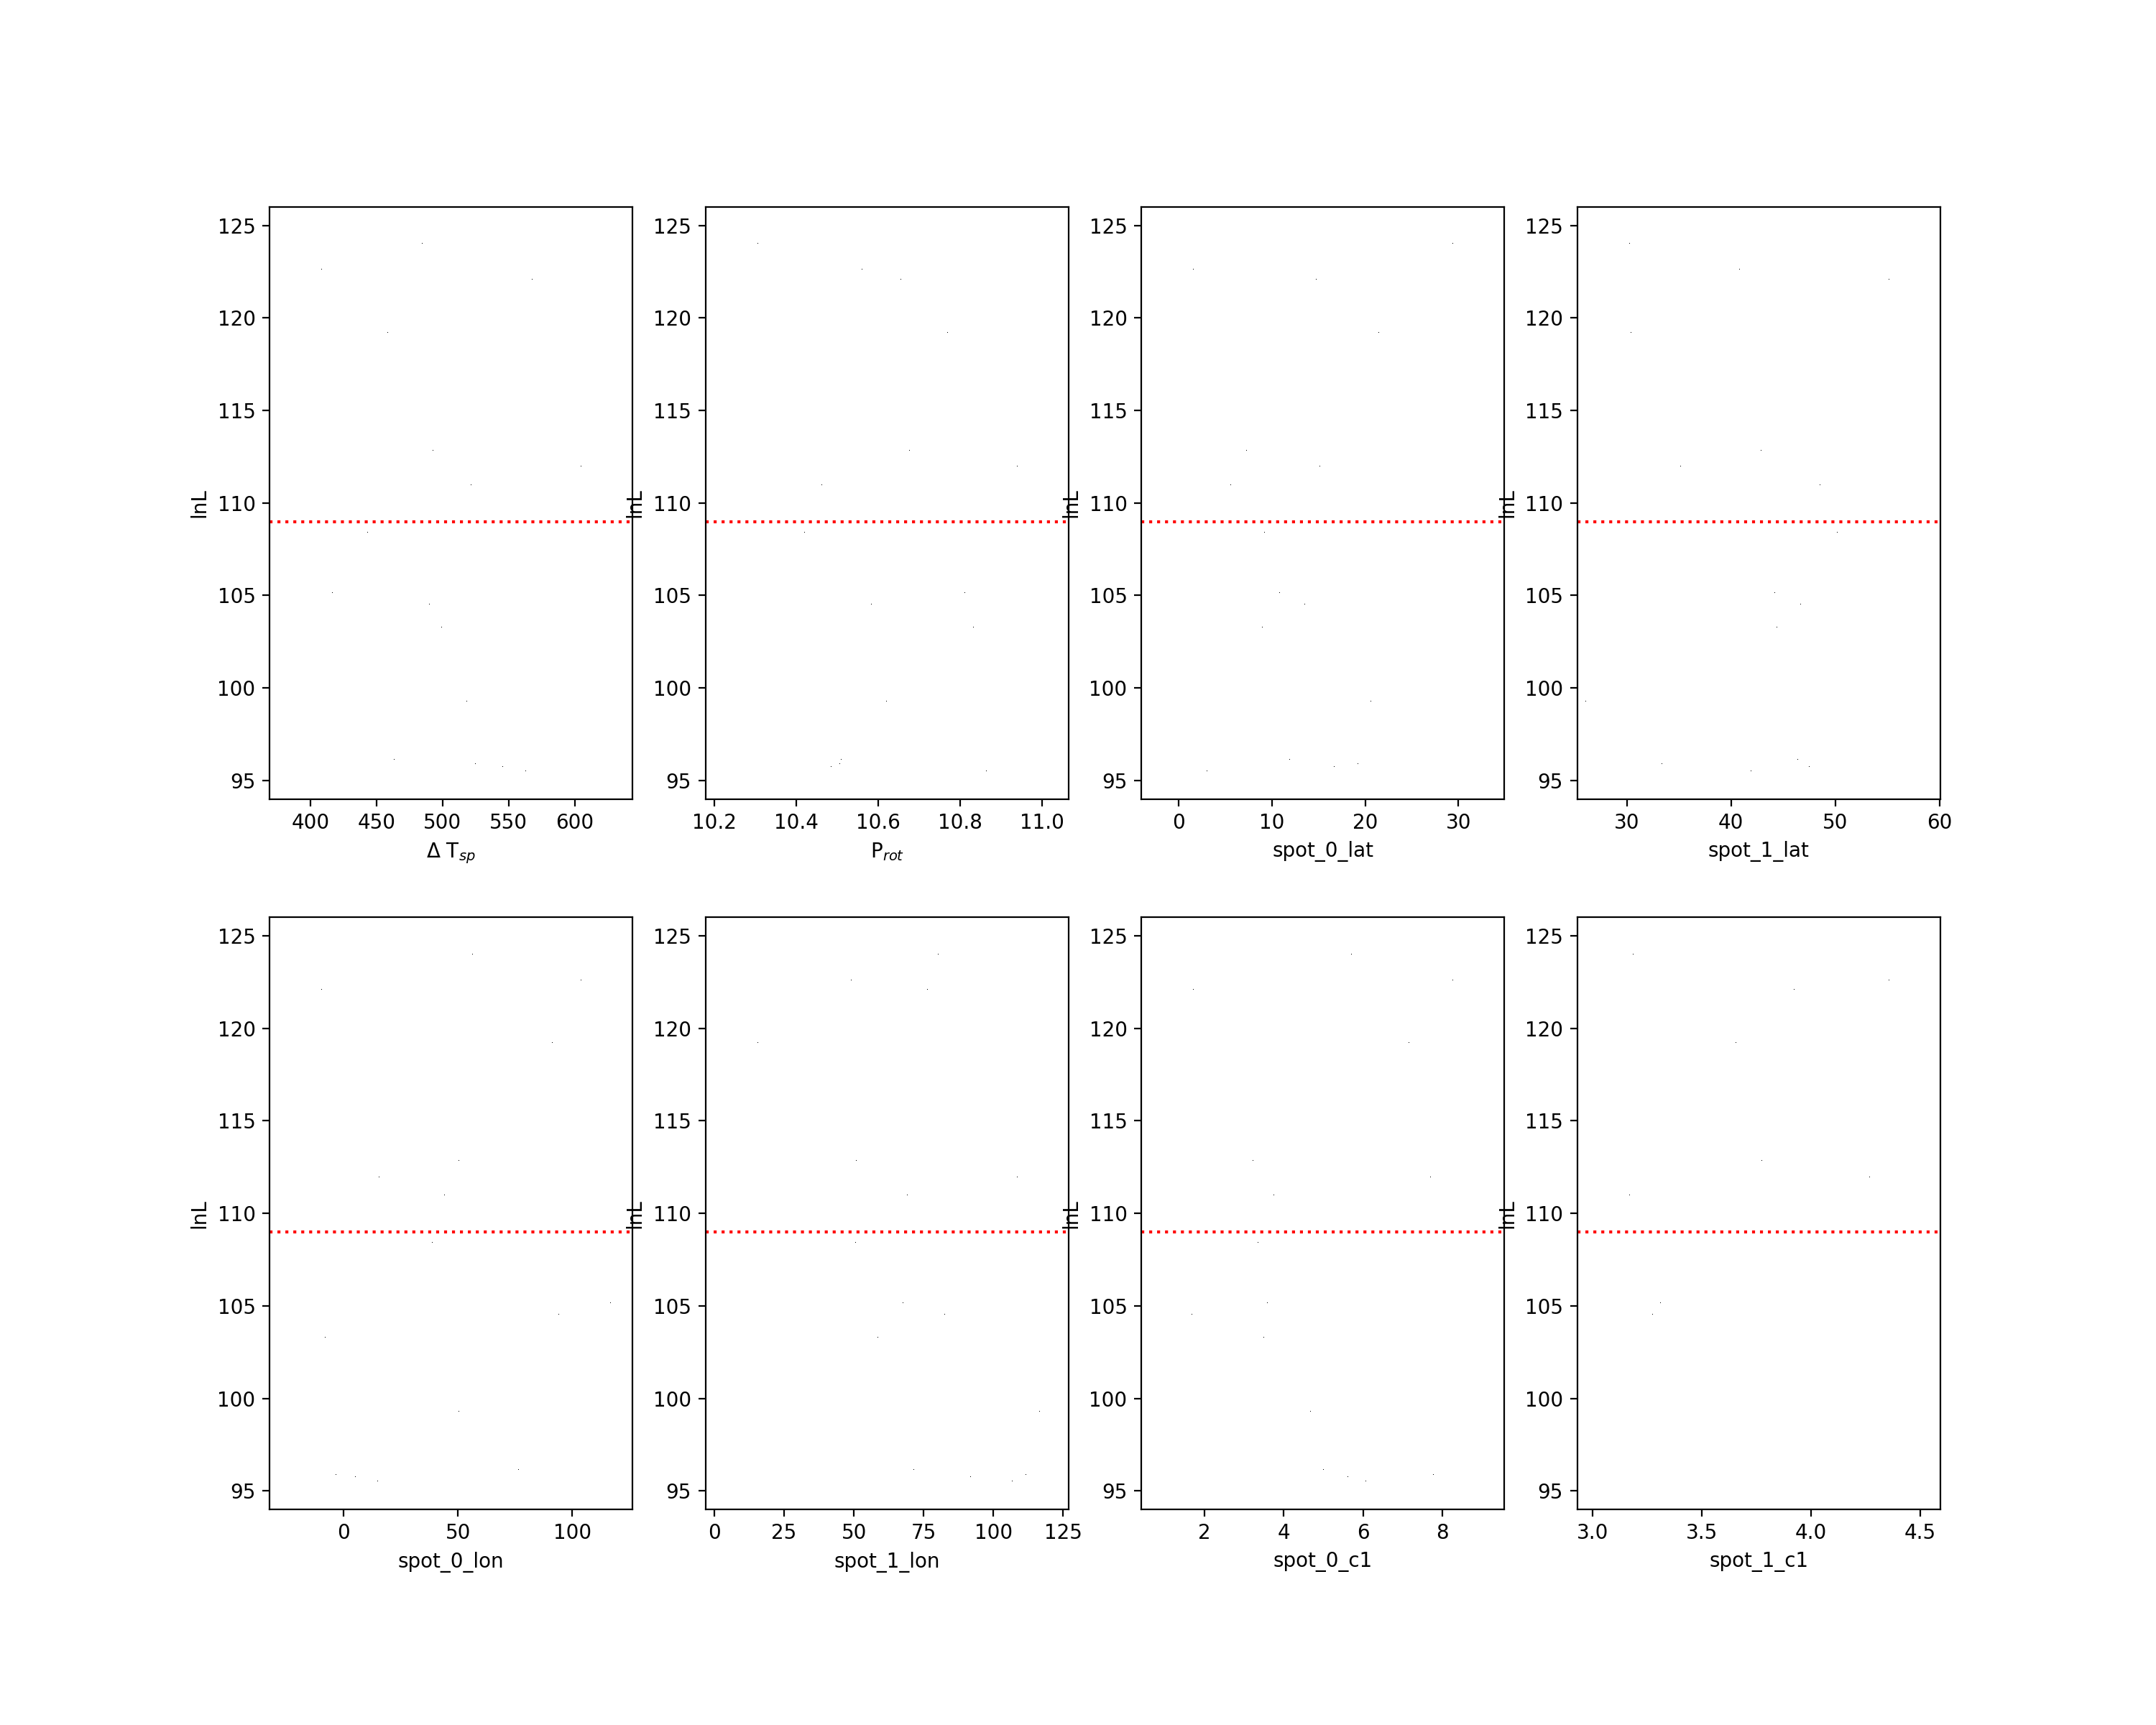

In [28]:
Image(filename='starsim/plots/MCMCoptimization_likelihoods.png',width=600) 

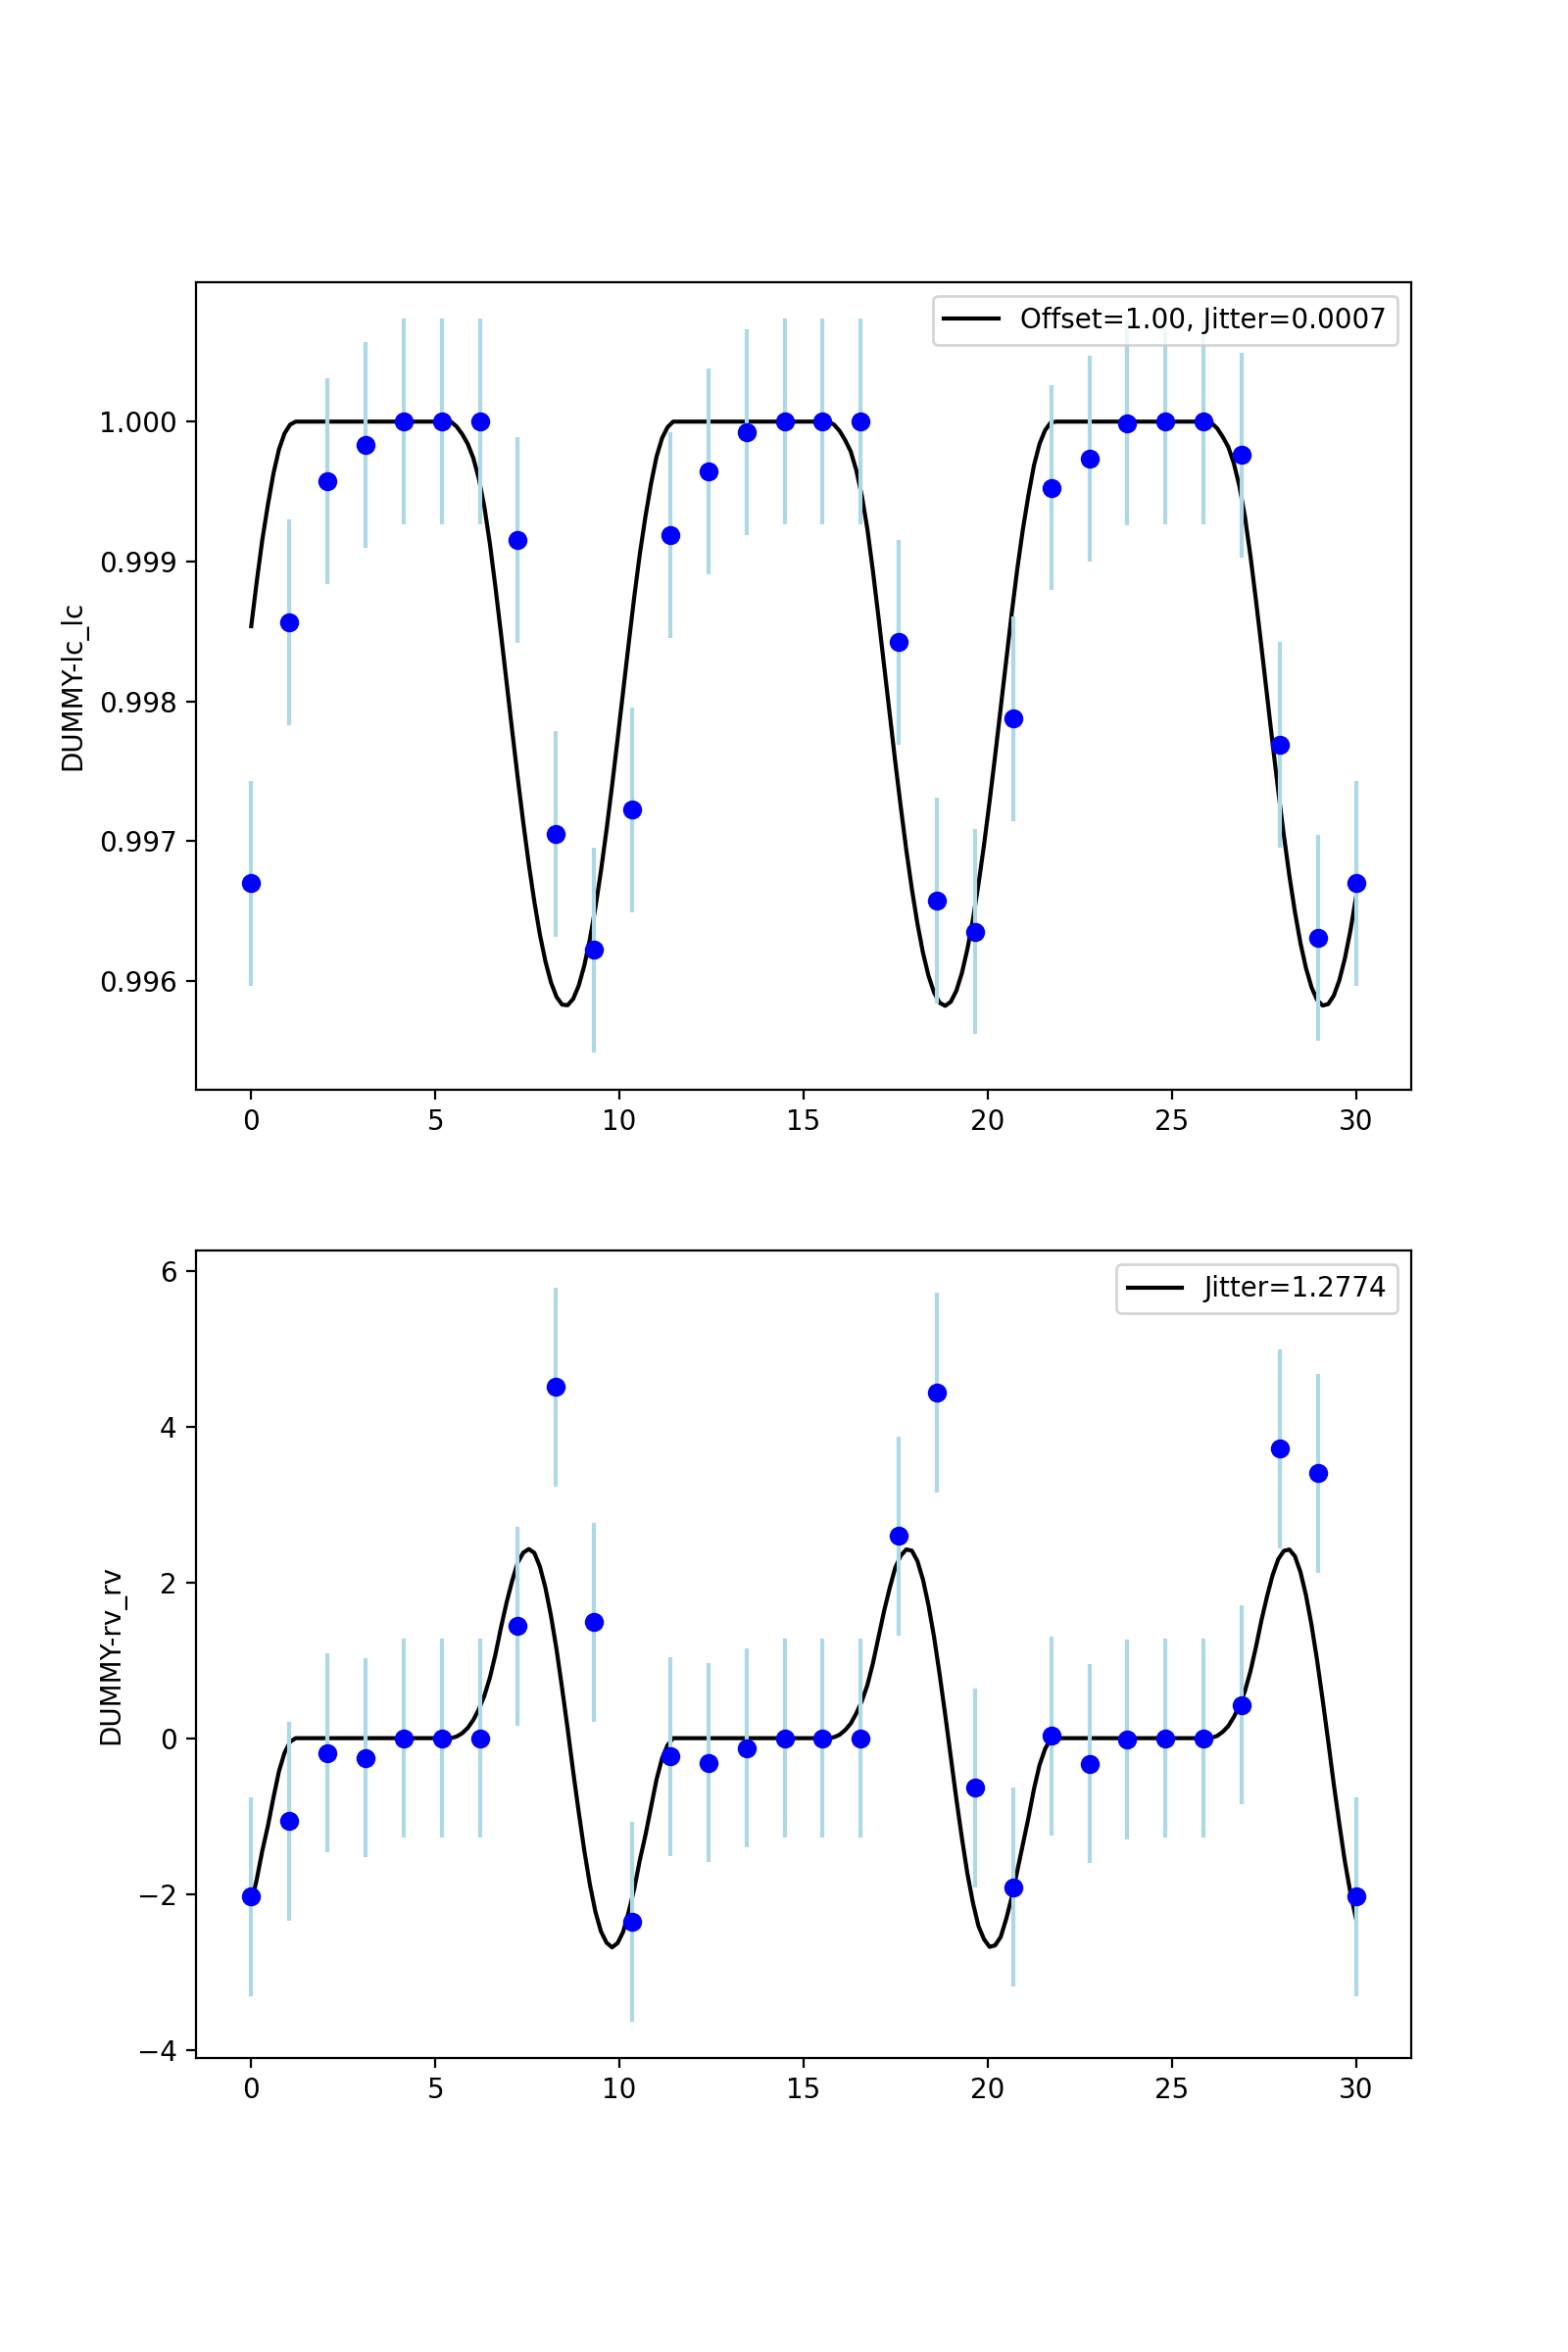

In [29]:

Image(filename='starsim/plots/MCMCoptimization_timeseries_best_result.png',width=300)